<a id="top"></a>
<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" role="tab" aria-controls="home">Table of Content</h3>

* [1. Libraries](#1)
* [2. Reading the Data](#2)
    - [1.1 An Overview from the Data](#2.1)
* [3. Exploratory Data Analysis](#3) 
    - [3.1 Total Orders on E-Commerce](#3.1)
    - [3.2 E-Commerce Around Brazil](#3.2)
    - [3.3 E-Commerce Impact on Economy](#3.3)
    - [3.4 Payment Type Analysis](#3.4)
    - [3.5 Seller Analysis](#3.5)
    - [3.6 Product Analysis](#3.6)
    - [3.7 Observation](#3.7)
* [4. Predictive Modelling for Delivey Time](#4)
    - [4.1 Understanding and Preparing Data](#4.1)
    - [4.2 Pre-processing](#4.2)
    - [4.3 Features Correlation](#4.3)
    - [4.4 Predictive Models](#4.4)
    - [4.5 Conclusion and Future Works](#4.5)
* [5. Time Series Analysis](#5)
* [6. Churn Prediction](#6)
* [7. Natural Language Processing](#7)

<a id="1"></a>
<font color="darkslateblue" size=+2.5><b>1. Libraries</b></font>

In [87]:
pip install folium --upgrade

  Using cached https://files.pythonhosted.org/packages/0e/0f/22068577bc5eafdcbf5521dbaed6a5317a434ad6847ad3711dee1fd1f6ba/folium-0.14.0-py2.py3-none-any.whl
  ERROR: Could not find a version that satisfies the requirement branca>=0.6.0 (from folium) (from versions: 0.1.1, 0.2.0, 0.3.0, 0.3.1, 0.4.0, 0.4.1, 0.4.2, 0.5.0)
ERROR: No matching distribution found for branca>=0.6.0 (from folium)
Note: you may need to restart the kernel to use updated packages.


In [88]:
# Standard libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.gridspec import GridSpec
pd.set_option('display.max_columns', 100)
import plotly.offline as py
import plotly.express as px
import plotly.graph_objs as go
import json
import requests
import folium
from folium.plugins import FastMarkerCluster, Fullscreen, MiniMap, HeatMap, HeatMapWithTime, LocateControl
from wordcloud import WordCloud
from collections import Counter
from PIL import Image

# Utilities
from viz_utils import *
from custom_transformers import *
from ml_utils import *

# DataPrep
import re
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import joblib

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb

<a id="2"></a>
<font color="darkslateblue" size=+2.5><b>2. Reading the Data</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>
The files are:

    olist_customers_dataset.csv
    olist_geolocation_dataset.csv
    olist_orders_dataset.csv
    olist_order_items_dataset.csv
    olist_order_payments_dataset.csv
    olist_order_reviews_dataset.csv
    olist_products_dataset.csv
    olist_sellers_dataset.csv
    product_category_name_translation.csv

In [89]:
# Reading all the files
raw_path = '../input/brazilian-ecommerce/'
olist_customer = pd.read_csv(raw_path + 'olist_customers_dataset.csv')
olist_geolocation = pd.read_csv(raw_path + 'olist_geolocation_dataset.csv')
olist_orders = pd.read_csv(raw_path + 'olist_orders_dataset.csv')
olist_order_items = pd.read_csv(raw_path + 'olist_order_items_dataset.csv')
olist_order_payments = pd.read_csv(raw_path + 'olist_order_payments_dataset.csv')
olist_order_reviews = pd.read_csv(raw_path + 'olist_order_reviews_dataset.csv')
olist_products = pd.read_csv(raw_path + 'olist_products_dataset.csv')
olist_sellers = pd.read_csv(raw_path + 'olist_sellers_dataset.csv')

<a id="2.1"></a>
<font color="dimgrey" size=+2.0><b>2.1 An Overview from the Data</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>
let's look at the shape of each datasets. 

In [90]:
# Collections for each dataset
datasets = [olist_customer, olist_geolocation, olist_orders, olist_order_items, olist_order_payments,
            olist_order_reviews, olist_products, olist_sellers]
names = ['olist_customer', 'olist_geolocation', 'olist_orders', 'olist_order_items', 'olist_order_payments',
         'olist_order_reviews', 'olist_products', 'olist_sellers']

# Creating a DataFrame with useful information about all datasets
data_info = pd.DataFrame({})
data_info['dataset'] = names
data_info['n_rows'] = [df.shape[0] for df in datasets]
data_info['n_cols'] = [df.shape[1] for df in datasets]
data_info['null_amount'] = [df.isnull().sum().sum() for df in datasets]
data_info['qty_null_columns'] = [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
data_info['null_columns'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]

data_info.style.background_gradient()

,dataset,n_rows,n_cols,null_amount,qty_null_columns,null_columns
0,olist_customer,99441,5,0,0,
1,olist_geolocation,1000163,5,0,0,
2,olist_orders,99441,8,4908,3,"order_approved_at, order_delivered_carrier_date, order_delivered_customer_date"
3,olist_order_items,112650,7,0,0,
4,olist_order_payments,103886,5,0,0,
5,olist_order_reviews,99224,7,145903,2,"review_comment_title, review_comment_message"
6,olist_products,32951,9,2448,8,"product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm"
7,olist_sellers,3095,4,0,0,


In [91]:
df_overview = pd.DataFrame({})
name_col = []
for name, df in zip(names, datasets):
#     print(name, "__", df.shape)
    name_col += [name] * df.shape[1]
    df_overview = df_overview.append(data_overview(df))
    df_overview['dataset_name'] = name_col

df_overview = df_overview.loc[:, ['dataset_name', 'feature', 'qtd_null', 'percent_null', 'dtype', 'qtd_cat']]
df_overview
# name_col

,dataset_name,feature,qtd_null,percent_null,dtype,qtd_cat
0,olist_customer,customer_id,0,0.000000,object,99441
1,olist_customer,customer_unique_id,0,0.000000,object,96096
2,olist_customer,customer_zip_code_prefix,0,0.000000,int64,0
3,olist_customer,customer_city,0,0.000000,object,4119
4,olist_customer,customer_state,0,0.000000,object,27
0,olist_geolocation,geolocation_zip_code_prefix,0,0.000000,int64,0
1,olist_geolocation,geolocation_lat,0,0.000000,float64,0
2,olist_geolocation,geolocation_lng,0,0.000000,float64,0
3,olist_geolocation,geolocation_city,0,0.000000,object,8011
4,olist_geolocation,geolocation_state,0,0.000000,object,27


Well, we can now use the DataFrame above wherever we want to do some data transformation or data analysis. It contains basically the main information about each column for each one of the datasets available. This is very useful!

<a id="3"></a>
<font color="darkslateblue" size=+2.5><b>3. Exploratory Data Analysis</b></font>

So now we will go trough an exploratory data analysis to get insights from E-Commerce in Brazil. The aim here is to divide this session into topics so we can explore graphics for each subject (orders, customers, products, items, and others).

<a id="3.1"></a>
<font color="dimgrey" size=+2.0><b>3.1 Total Orders on E-Commerce</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>

Looking at the dataset columns, we can see orders with different `status` and with different timestamp columns like `purchase`, `approved`, `delivered` and `estimated delivery`. First, let's look at the status of the orders we have in this dataset.

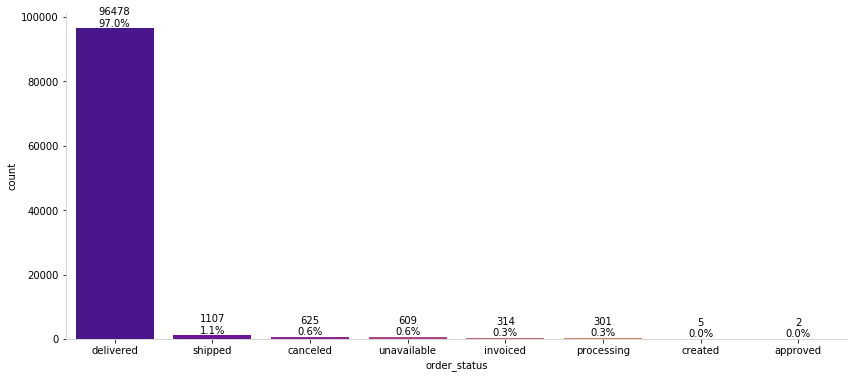

In [92]:
# How many orders we have for each status
df_orders = olist_orders.merge(olist_customer, how='left', on='customer_id')
fig, ax = plt.subplots(figsize=(14, 6))
single_countplot(df_orders, x='order_status', ax=ax)
plt.show()

By the time this dataset was created, the highest amount of orders went from delivered ones. Only 3% of all orders came from the other status.

In [93]:
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


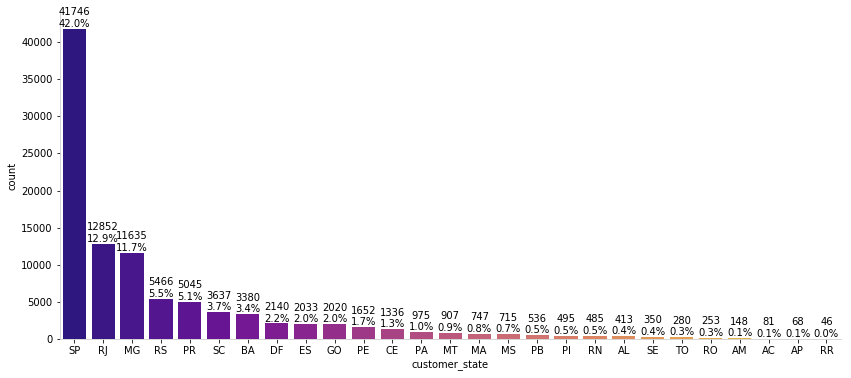

In [94]:
# customer states count
fig, ax = plt.subplots(figsize=(14, 6))
single_countplot(df_orders, x='customer_state', ax=ax)
plt.show()

Almost 65% orders are coming from SP, RJ and MG states. This will be helpful, if we can make delivery faster here.

In [95]:
# Changing the data type for date columns
timestamp_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
                  'order_estimated_delivery_date']
for col in timestamp_cols:
    df_orders[col] = pd.to_datetime(df_orders[col])
    
# Extracting attributes for purchase date - Year and Month
df_orders['order_purchase_year'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.year)
df_orders['order_purchase_month'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.month)
df_orders['order_purchase_month_name'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%b'))
df_orders['order_purchase_year_month'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m'))
df_orders['order_purchase_date'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m%d'))

# Extracting attributes for purchase date - Day and Day of Week
df_orders['order_purchase_day'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.day)
df_orders['order_purchase_dayofweek'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.dayofweek)
df_orders['order_purchase_dayofweek_name'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%a'))

# Extracting attributes for purchase date - Hour and Time of the Day
df_orders['order_purchase_hour'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.hour)
hours_bins = [-0.1, 6, 12, 18, 23]
hours_labels = ['Dawn', 'Morning', 'Afternoon', 'Night']
df_orders['order_purchase_time_day'] = pd.cut(df_orders['order_purchase_hour'], hours_bins, labels=hours_labels)

# New DataFrame after transformations
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017,10,Oct,201710,20171002,2,0,Mon,10,Morning
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018,7,Jul,201807,20180724,24,1,Tue,20,Night
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018,8,Aug,201808,20180808,8,2,Wed,8,Morning
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017,11,Nov,201711,20171118,18,5,Sat,19,Night
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2018,2,Feb,201802,20180213,13,1,Tue,21,Night


So now we can purpose a complete analysis on orders amount of brazilian e-commerce during the period of the dataset.

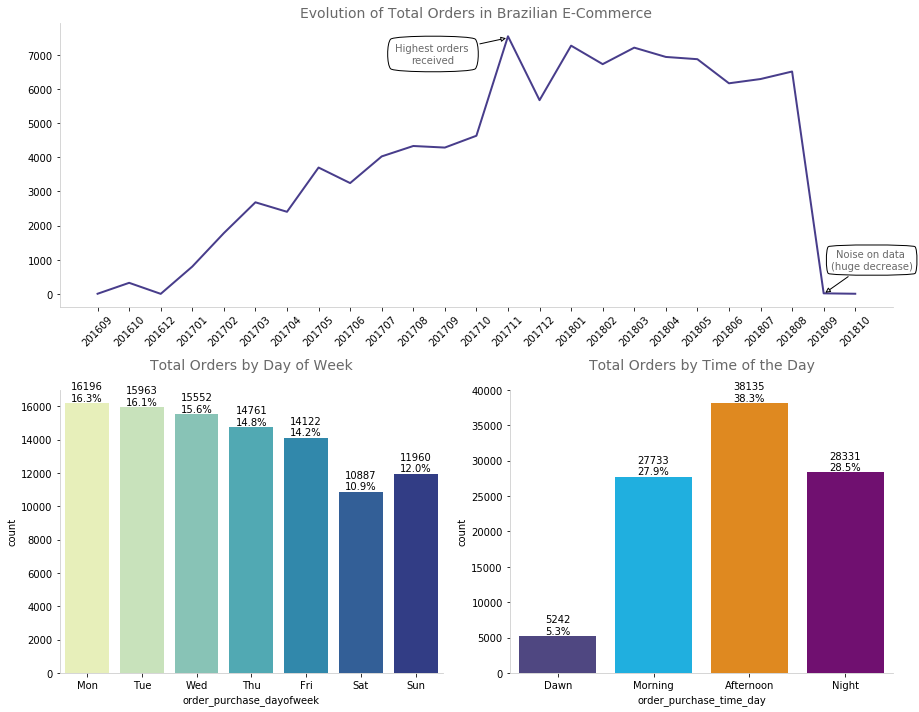

In [96]:
fig = plt.figure(constrained_layout=True, figsize=(13, 10))

# Axis definition
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

# Lineplot - Evolution of e-commerce orders along time 
sns.lineplot(data=df_orders['order_purchase_year_month'].value_counts().sort_index(), ax=ax1, 
             color='darkslateblue', linewidth=2)
ax1.annotate(f'Highest orders \nreceived', (13, 7500), xytext=(-75, -25), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.8),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')
ax1.annotate(f'Noise on data \n(huge decrease)', (23, 0), xytext=(48, 25), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.5),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')
format_spines(ax1, right_border=False)  
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
ax1.set_title('Evolution of Total Orders in Brazilian E-Commerce', size=14, color='dimgrey')

# Barchart - Total of orders by day of week
single_countplot(df_orders, x='order_purchase_dayofweek', ax=ax2, order=False, palette='YlGnBu')
weekday_label = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax2.set_xticklabels(weekday_label)
ax2.set_title('Total Orders by Day of Week', size=14, color='dimgrey', pad=20)

# Barchart - Total of orders by time of the day
day_color_list = ['darkslateblue', 'deepskyblue', 'darkorange', 'purple']
single_countplot(df_orders, x='order_purchase_time_day', ax=ax3, order=False, palette=day_color_list)
ax3.set_title('Total Orders by Time of the Day', size=14, color='dimgrey', pad=20)

plt.tight_layout()
plt.show()

By the chart above we can conclude:

* E-commerce on Brazil really has a growing trend along the time. We can see some seasonality with peaks at specific months, but in general we can see clear that customers are more prone to buy things online than before.
* Monday are the prefered day for brazilian's customers and they tend to buy more at afternoons.

_Obs: we have a sharp decrease between August 2018 and September 2018 and maybe the origin of that is related to noise on data. For further comparison between 2017 and 2018, let's just consider orders between January and August in both years_

___
* _E-commerce: a comparison between 2017 and 2018_
___

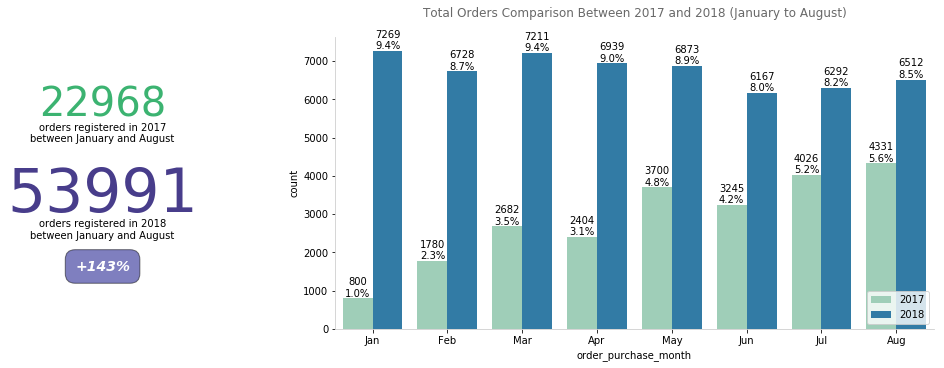

In [97]:
# Creating figure
fig = plt.figure(constrained_layout=True, figsize=(13, 5))

# Axis definition
gs = GridSpec(1, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1:])

# Annotation - Grown on e-commerce orders between 2017 and 2018
df_orders_compare = df_orders.query('order_purchase_year in (2017, 2018) & order_purchase_month <= 8')
year_orders = df_orders_compare['order_purchase_year'].value_counts()
growth = int(round(100 * (1 + year_orders[2017] / year_orders[2018]), 0))
ax1.text(0.00, 0.73, f'{year_orders[2017]}', fontsize=40, color='mediumseagreen', ha='center')
ax1.text(0.00, 0.64, 'orders registered in 2017\nbetween January and August', fontsize=10, ha='center')
ax1.text(0.00, 0.40, f'{year_orders[2018]}', fontsize=60, color='darkslateblue', ha='center')
ax1.text(0.00, 0.31, 'orders registered in 2018\nbetween January and August', fontsize=10, ha='center')
signal = '+' if growth > 0 else '-'
ax1.text(0.00, 0.20, f'{signal}{growth}%', fontsize=14, ha='center', color='white', style='italic', weight='bold',
         bbox=dict(facecolor='navy', alpha=0.5, pad=10, boxstyle='round, pad=.7'))
ax1.axis('off')

# Bar chart - Comparison between monthly sales between 2017 and 2018
single_countplot(df_orders_compare, x='order_purchase_month', hue='order_purchase_year', ax=ax2, order=False,
                 palette='YlGnBu')
month_label = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']
ax2.set_xticklabels(month_label)
ax2.set_title('Total Orders Comparison Between 2017 and 2018 (January to August)', size=12, color='dimgrey', pad=20)
plt.legend(loc='lower right')
plt.show()

We can see a pattern that every month(Jan to Aug) of 2018 number of orders have been increased significantly from year 2017. 

<a id="3.2"></a>
<font color="dimgrey" size=+2.0><b>3.2 E-Commerce Around Brazil</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>

In [98]:
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017,10,Oct,201710,20171002,2,0,Mon,10,Morning
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018,7,Jul,201807,20180724,24,1,Tue,20,Night
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018,8,Aug,201808,20180808,8,2,Wed,8,Morning
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017,11,Nov,201711,20171118,18,5,Sat,19,Night
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2018,2,Feb,201802,20180213,13,1,Tue,21,Night


In [99]:
# Merging orders and order_items
df_orders_items = df_orders.merge(olist_order_items, how='left', on='order_id')

# Using the API to bring the region to the data
r = requests.get('https://servicodados.ibge.gov.br/api/v1/localidades/mesorregioes')
content = [c['UF'] for c in json.loads(r.text)]
br_info = pd.DataFrame(content)
br_info['nome_regiao'] = br_info['regiao'].apply(lambda x: x['nome'])
br_info.drop('regiao', axis=1, inplace=True)
br_info.drop_duplicates(inplace=True)

# Threting geolocations outside brazilian map

#Brazils most Northern spot is at 5 deg 16′ 27.8″ N latitude.;
geo_prep = olist_geolocation[olist_geolocation.geolocation_lat <= 5.27438888]
#it’s most Western spot is at 73 deg, 58′ 58.19″W Long.
geo_prep = geo_prep[geo_prep.geolocation_lng >= -73.98283055]
#It’s most southern spot is at 33 deg, 45′ 04.21″ S Latitude.
geo_prep = geo_prep[geo_prep.geolocation_lat >= -33.75116944]
#It’s most Eastern spot is 34 deg, 47′ 35.33″ W Long.
geo_prep = geo_prep[geo_prep.geolocation_lng <=  -34.79314722]
geo_group = geo_prep.groupby(by='geolocation_zip_code_prefix', as_index=False).min()

# Merging all the informations
df_orders_items = df_orders_items.merge(br_info, how='left', left_on='customer_state', right_on='sigla')
df_orders_items = df_orders_items.merge(geo_group, how='left', left_on='customer_zip_code_prefix', 
                                        right_on='geolocation_zip_code_prefix')
df_orders_items.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,id,sigla,nome,nome_regiao,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017,10,Oct,201710,20171002,2,0,Mon,10,Morning,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,35,SP,São Paulo,Sudeste,3149.0,-23.583885,-46.587473,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018,7,Jul,201807,20180724,24,1,Tue,20,Night,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,29,BA,Bahia,Nordeste,47813.0,-12.945892,-45.016313,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018,8,Aug,201808,20180808,8,2,Wed,8,Morning,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,52,GO,Goiás,Centro-Oeste,75265.0,-16.752735,-48.522139,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017,11,Nov,201711,20171118,18,5,Sat,19,Night,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,24,RN,Rio Grande do Norte,Nordeste,59296.0,-5.778488,-35.281450,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2018,2,Feb,201802,20180213,13,1,Tue,21,Night,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,35,SP,São Paulo,Sudeste,9195.0,-23.760018,-46.524784,santo andre,SP


In [100]:
cnt18 = df_orders_items.query('order_purchase_year == 2018')['geolocation_lat'].dropna().shape
cnt17 = df_orders_items.query('order_purchase_year == 2017')['geolocation_lat'].dropna().shape
cnt16 = df_orders_items.query('order_purchase_year == 2016')['geolocation_lat'].dropna().shape
print(df_orders_items["order_purchase_year"].unique(), "2016: ", cnt16[0], "2017: ",cnt17[0], "2018: ", cnt18[0])

[2017 2018 2016] 2016:  387 2017:  51246 2018:  61485


In [101]:
print("Mininum year month: ", df_orders_items["order_purchase_year_month"].min())
print("Maximum year month: ", df_orders_items["order_purchase_year_month"].max())

Mininum year month:  201609
Maximum year month:  201810


Data collection is done from Aug 2016, thats is why there is drop in number of orders in this year. But it's clear that there is growth in number of orders from yoy (2017 to 2018)of almost **20%**.

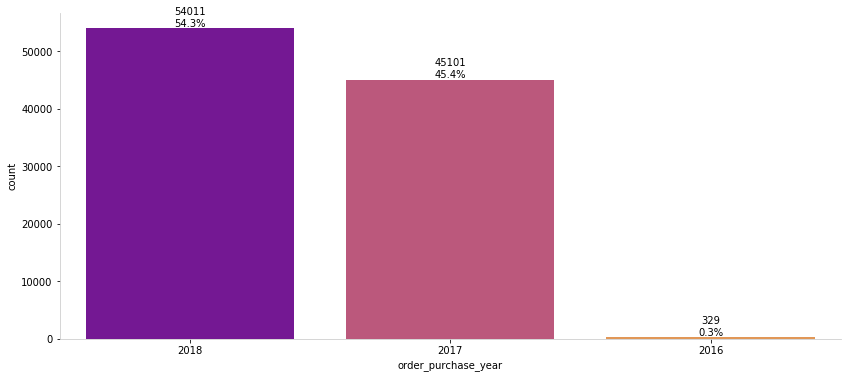

In [102]:
# year wise orders
fig, ax = plt.subplots(figsize=(14, 6))
single_countplot(df_orders, x='order_purchase_year', ax=ax)
plt.show()

In [103]:
# Zipping locations
lats = list(df_orders_items.query('order_purchase_year == 2018')['geolocation_lat'].dropna().values)[:30000]
longs = list(df_orders_items.query('order_purchase_year == 2018')['geolocation_lng'].dropna().values)[:30000]
locations = list(zip(lats, longs))

# Creating a map using folium
map1 = folium.Map(location=[-15, -50], zoom_start=4.0)

# Plugin: FastMarkerCluster
FastMarkerCluster(data=locations).add_to(map1)

map1

By the map we showed above, we have already the insight that the southeast of Brazil has the highest number of orders given through e-commerce. 

<a id="3.3"></a>
<font color="dimgrey" size=+2.0><b>3.3 E-Commerce Impact on Economy</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>

Until now, we just answered questions on E-commerce scenario considering the number of orders received. We could see the volumetry amonth months, day of week, time of the day and even the geolocation states.

Now, we will analyze the money movemented by e-commerce by looking at order prices, freights and others.

In [104]:
# Filtering data between 201701 and 201808
df_orders_filt = df_orders_items[(df_orders_items['order_purchase_year_month'].astype(int) >= 201701)]
df_orders_filt = df_orders_filt[(df_orders_filt['order_purchase_year_month'].astype(int) <= 201808)]
df_orders_filt.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,id,sigla,nome,nome_regiao,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017,10,Oct,201710,20171002,2,0,Mon,10,Morning,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,35,SP,São Paulo,Sudeste,3149.0,-23.583885,-46.587473,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018,7,Jul,201807,20180724,24,1,Tue,20,Night,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,29,BA,Bahia,Nordeste,47813.0,-12.945892,-45.016313,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018,8,Aug,201808,20180808,8,2,Wed,8,Morning,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,52,GO,Goiás,Centro-Oeste,75265.0,-16.752735,-48.522139,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017,11,Nov,201711,20171118,18,5,Sat,19,Night,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,24,RN,Rio Grande do Norte,Nordeste,59296.0,-5.778488,-35.281450,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2018,2,Feb,201802,20180213,13,1,Tue,21,Night,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,35,SP,São Paulo,Sudeste,9195.0,-23.760018,-46.524784,santo andre,SP


In [105]:
# Grouping data
df_month_aggreg = df_orders_filt.groupby(by=['order_purchase_year', 'order_purchase_year_month'], as_index=False)
df_month_aggreg = df_month_aggreg.agg({
    'order_id': 'count',
    'price': 'sum',
    'freight_value': 'sum'
})

df_month_aggreg.head()

,order_purchase_year,order_purchase_year_month,order_id,price,freight_value
0,2017,201701,966,120312.87,16875.62
1,2017,201702,1998,247303.02,38977.60
2,2017,201703,3041,374344.30,57704.29
3,2017,201704,2697,359927.23,52495.01
4,2017,201705,4176,506071.14,80119.81


In [106]:
# Adding new columns for analysis
df_month_aggreg['price_per_order'] = df_month_aggreg['price'] / df_month_aggreg['order_id']
df_month_aggreg['freight_per_order'] = df_month_aggreg['freight_value'] / df_month_aggreg['order_id']
df_month_aggreg.head()

,order_purchase_year,order_purchase_year_month,order_id,price,freight_value,price_per_order,freight_per_order
0,2017,201701,966,120312.87,16875.62,124.547484,17.469586
1,2017,201702,1998,247303.02,38977.60,123.775285,19.508308
2,2017,201703,3041,374344.30,57704.29,123.099079,18.975432
3,2017,201704,2697,359927.23,52495.01,133.454664,19.464223
4,2017,201705,4176,506071.14,80119.81,121.185618,19.185778


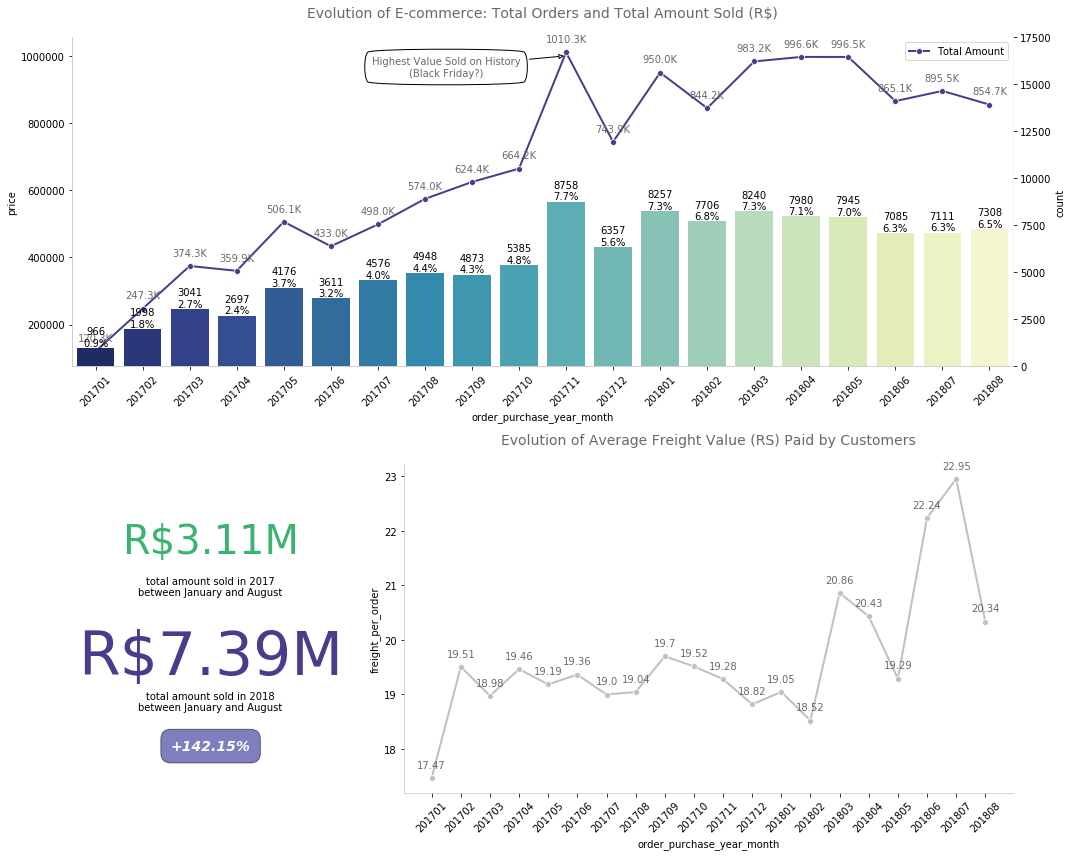

In [107]:
# Creating figure
fig = plt.figure(constrained_layout=True, figsize=(15, 12))

# Axis definition
gs = GridSpec(2, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1:])

# Plot 1 - Evolution of total orders and total sales on e-commerce
sns.lineplot(x='order_purchase_year_month', y='price', ax=ax1, data=df_month_aggreg, linewidth=2, 
             color='darkslateblue', marker='o', label='Total Amount')
ax1_twx = ax1.twinx()
single_countplot(df_orders_filt, x='order_purchase_year_month', ax=ax1_twx, order=False, palette='YlGnBu_r')
ax1_twx.set_yticks(np.arange(0, 20000, 2500))

# Customizing the first plot
format_spines(ax1)
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
for x, y in df_month_aggreg.price.items():
    ax1.annotate(str(round(y/1000, 1))+'K', xy=(x, y), textcoords='offset points', xytext=(0, 10),
                ha='center', color='dimgrey')
ax1.annotate(f'Highest Value Sold on History\n(Black Friday?)', (10, 1000000), xytext=(-120, -20), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.8),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')
ax1.set_title('Evolution of E-commerce: Total Orders and Total Amount Sold (R$)', size=14, color='dimgrey', pad=20)

# Plot 2 - Big Numbers of Sales Evolution
month_comparison = ['201701', '201702', '201703', '201704', '201705', '201706', '201707', '201708',
                    '201801', '201802', '201803', '201804', '201805', '201806', '201807', '201808']
df_sales_compare = df_month_aggreg.query('order_purchase_year_month in (@month_comparison)')
sold_2017 = df_sales_compare.query('order_purchase_year == 2017')['price'].sum()
sold_2018 = df_sales_compare.query('order_purchase_year == 2018')['price'].sum()
growth = 1 + (sold_2017 / sold_2018)
ax2.text(0.50, 0.73, 'R$' + str(round(sold_2017/1000000, 2)) + 'M', fontsize=40, color='mediumseagreen', ha='center')
ax2.text(0.50, 0.60, 'total amount sold in 2017\nbetween January and August', fontsize=10, ha='center')
ax2.text(0.50, 0.36, 'R$' + str(round(sold_2018/1000000, 2)) + 'M', fontsize=60, color='darkslateblue', ha='center')
ax2.text(0.50, 0.25, 'total amount sold in 2018\nbetween January and August', fontsize=10, ha='center')
signal = '+' if growth > 0 else '-'
ax2.text(0.50, 0.13, f'{signal}{str(round(100 * growth, 2))}%', fontsize=14, ha='center', color='white', style='italic', weight='bold',
         bbox=dict(facecolor='navy', alpha=0.5, pad=10, boxstyle='round, pad=.7'))
ax2.axis('off')

# Plot 3 - Evolution of mean freight value paid by the customers
sns.lineplot(x='order_purchase_year_month', y='freight_per_order', data=df_month_aggreg, linewidth=2, 
             color='silver', marker='o', ax=ax3)
format_spines(ax3, right_border=False)
for tick in ax3.get_xticklabels():
    tick.set_rotation(45)
for x, y in df_month_aggreg.freight_per_order.items():
    ax3.annotate(round(y, 2), xy=(x, y), textcoords='offset points', xytext=(0, 10),
                ha='center', color='dimgrey')
ax3.set_title('Evolution of Average Freight Value (RS) Paid by Customers', size=14, color='dimgrey', pad=20)

plt.tight_layout()
plt.show()

Highest sales came in Nov 2017, it is beacuse of Black friday.

In [108]:
print("2017 Nov month orders: ", len(df_orders_filt[df_orders_filt["order_purchase_year_month"] == "201711"]))
print("2017 Black friday orders: ", len(df_orders_filt[df_orders_filt["order_purchase_date"] == "20171124"]))

2017 Nov month orders:  8758
2017 Black friday orders:  1376


___
* _How the total sales (sum of price) are concentraded in brazilian states?_
___

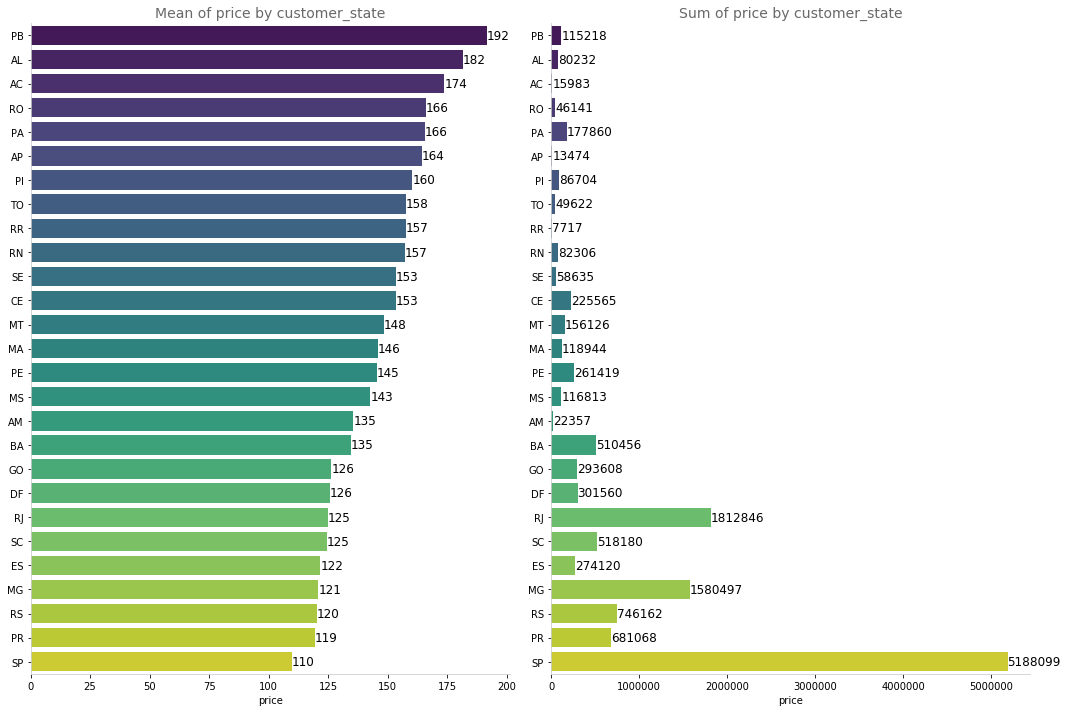

In [109]:
mean_sum_analysis(df_orders_filt, 'customer_state', 'price', palette='viridis', figsize=(15, 10))

It's very interesting to see how some states have a high total amount sold and a low price per order. If we look at SP (São Paulo) for example, it's possible to see that it is the state with most valuable state for e-commerce (5,188,099 sold) but it is also where customers pay less per order (110.00 per order).

How about the freight?

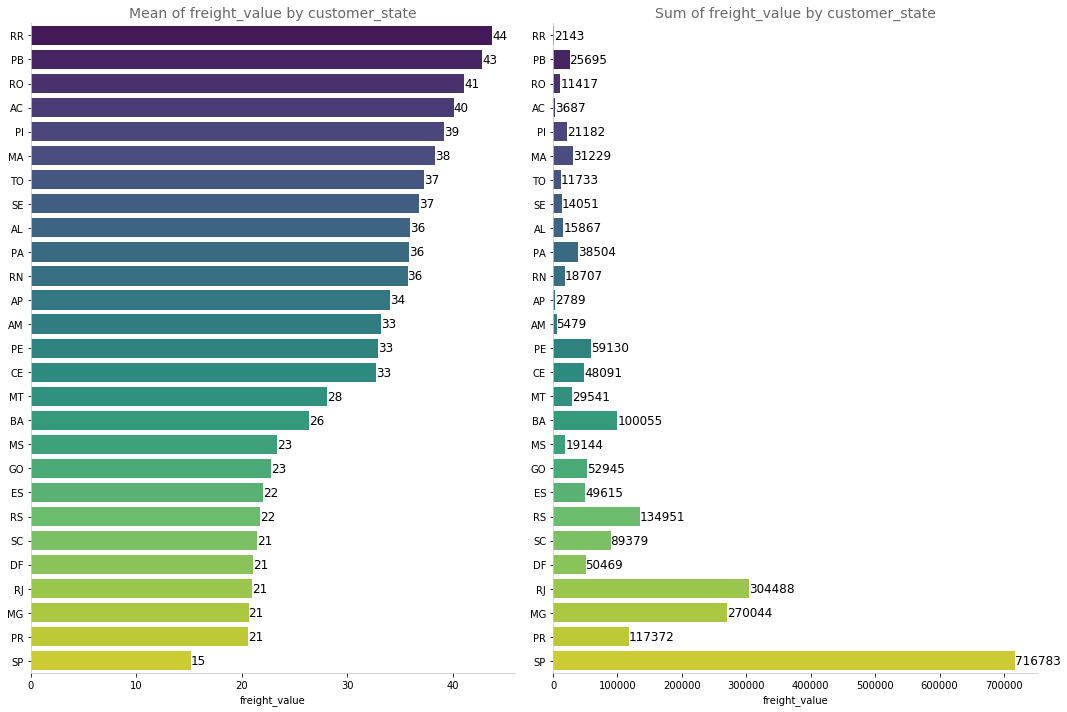

In [110]:
mean_sum_analysis(df_orders_filt, 'customer_state', 'freight_value', palette='viridis', figsize=(15, 10))

Here we can get insights about the customers states with highest mean freight value. For example, customers in Roraima (RR), Paraíba (PB), Rondônia (RO) and Acre (AC) normaly pays more than anyone on freights.

___
* _What are the best states to buy in Brazil? An analysis on sales, freight and delivery time_
___

In [111]:
# Calculating working days between purchasing, delivering and estimated delivery
purchasing = df_orders_filt['order_purchase_timestamp']
delivered = df_orders_filt['order_delivered_customer_date']
estimated = df_orders_filt['order_estimated_delivery_date']
df_orders_filt['time_to_delivery'] = calc_working_days(purchasing, delivered, convert=True)
df_orders_filt['diff_estimated_delivery'] = calc_working_days(estimated, delivered, convert=True)

# Grouping data by state
states_avg_grouped = df_orders_filt.groupby(by='customer_state', as_index=False).mean()
states_freight_paid = states_avg_grouped.loc[:, ['customer_state', 'freight_value']]
states_time_to_delivery = states_avg_grouped.loc[:, ['customer_state', 'time_to_delivery']]
states_estimated_delivery = states_avg_grouped.loc[:, ['customer_state', 'diff_estimated_delivery']]

# Sorting data
states_freight_paid = states_freight_paid.sort_values(by='freight_value', ascending=False)
states_time_to_delivery = states_time_to_delivery.sort_values(by='time_to_delivery', ascending=False)
states_estimated_delivery = states_estimated_delivery.sort_values(by='diff_estimated_delivery')

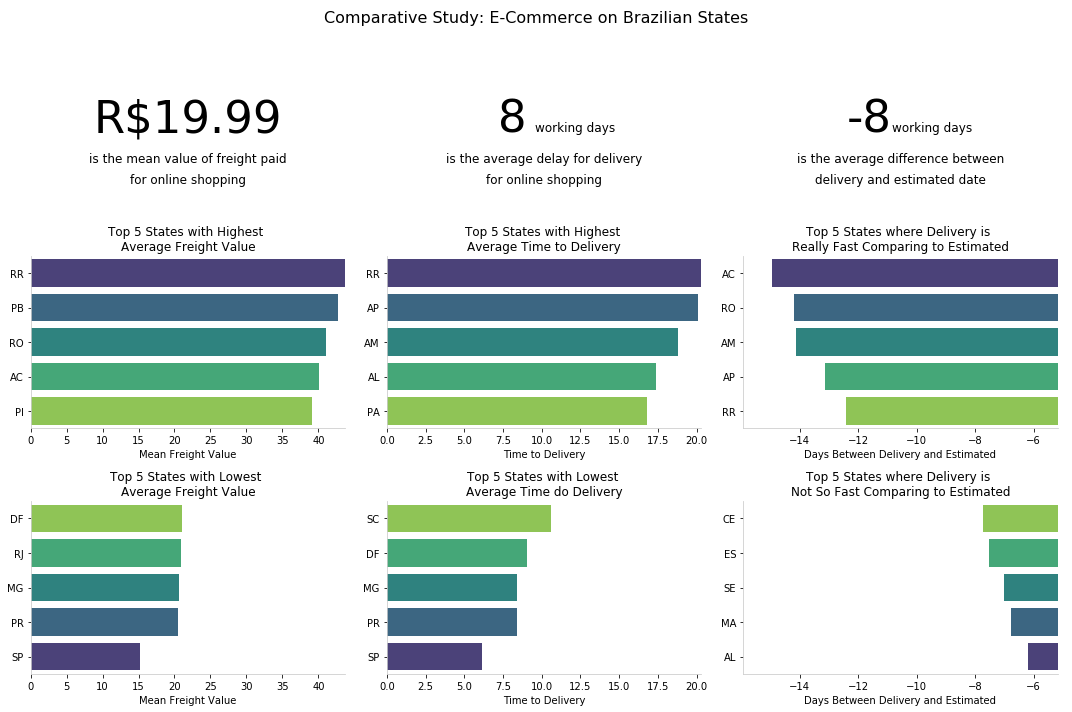

In [112]:
fig, axs = plt.subplots(3, 3, figsize=(15, 10))

# Plot Pack 01 - Freight value paid on states
sns.barplot(x='freight_value', y='customer_state', data=states_freight_paid.head(), ax=axs[1, 0], palette='viridis')
axs[1, 0].set_title('Top 5 States with Highest \nAverage Freight Value', size=12, color='black')
sns.barplot(x='freight_value', y='customer_state', data=states_freight_paid.tail(), ax=axs[2, 0], palette='viridis_r')
axs[2, 0].set_title('Top 5 States with Lowest \nAverage Freight Value', size=12, color='black')
for ax in axs[1, 0], axs[2, 0]:
    ax.set_xlabel('Mean Freight Value')
    ax.set_xlim(0, states_freight_paid['freight_value'].max())
    format_spines(ax, right_border=False)
    ax.set_ylabel('')

# Annotations
axs[0, 0].text(0.50, 0.30, f'R${round(df_orders_filt.freight_value.mean(), 2)}', fontsize=45, ha='center')
axs[0, 0].text(0.50, 0.12, 'is the mean value of freight paid', fontsize=12, ha='center')
axs[0, 0].text(0.50, 0.00, 'for online shopping', fontsize=12, ha='center')
axs[0, 0].axis('off')

# Plot Pack 02 - Time to delivery on states
sns.barplot(x='time_to_delivery', y='customer_state', data=states_time_to_delivery.head(), ax=axs[1, 1], palette='viridis')
axs[1, 1].set_title('Top 5 States with Highest \nAverage Time to Delivery', size=12, color='black')
sns.barplot(x='time_to_delivery', y='customer_state', data=states_time_to_delivery.tail(), ax=axs[2, 1], palette='viridis_r')
axs[2, 1].set_title('Top 5 States with Lowest \nAverage Time do Delivery', size=12, color='black')
for ax in axs[1, 1], axs[2, 1]:
    ax.set_xlabel('Time to Delivery')
    ax.set_xlim(0, states_time_to_delivery['time_to_delivery'].max())
    format_spines(ax, right_border=False)
    ax.set_ylabel('')
    
# Annotations
axs[0, 1].text(0.40, 0.30, f'{int(df_orders_filt.time_to_delivery.mean())}', fontsize=45, ha='center')
axs[0, 1].text(0.60, 0.30, 'working days', fontsize=12, ha='center')
axs[0, 1].text(0.50, 0.12, 'is the average delay for delivery', fontsize=12, ha='center')
axs[0, 1].text(0.50, 0.00, 'for online shopping', fontsize=12, ha='center')
axs[0, 1].axis('off')
    
# Plot Pack 03 - Differnece between delivered and estimated on states
sns.barplot(x='diff_estimated_delivery', y='customer_state', data=states_estimated_delivery.head(), ax=axs[1, 2], palette='viridis')
axs[1, 2].set_title('Top 5 States where Delivery is \nReally Fast Comparing to Estimated', size=12, color='black')
sns.barplot(x='diff_estimated_delivery', y='customer_state', data=states_estimated_delivery.tail(), ax=axs[2, 2], palette='viridis_r')
axs[2, 2].set_title('Top 5 States where Delivery is \nNot So Fast Comparing to Estimated', size=12, color='black')
for ax in axs[1, 2], axs[2, 2]:
    ax.set_xlabel('Days Between Delivery and Estimated')
    ax.set_xlim(states_estimated_delivery['diff_estimated_delivery'].min()-1, 
                states_estimated_delivery['diff_estimated_delivery'].max()+1)
    format_spines(ax, right_border=False)
    ax.set_ylabel('')

# Annotations
axs[0, 2].text(0.40, 0.30, f'{int(df_orders_filt.diff_estimated_delivery.mean())}', fontsize=45, ha='center')
axs[0, 2].text(0.60, 0.30, 'working days', fontsize=12, ha='center')
axs[0, 2].text(0.50, 0.12, 'is the average difference between', fontsize=12, ha='center')
axs[0, 2].text(0.50, 0.00, 'delivery and estimated date', fontsize=12, ha='center')
axs[0, 2].axis('off') 
    
plt.suptitle('Comparative Study: E-Commerce on Brazilian States', size=16)
plt.tight_layout()
plt.show()

<a id="3.4"></a>
<font color="dimgrey" size=+2.0><b>3.4 Payment Type Analysis</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>

One of the datasets provided have informations about order's payment. To see how payments can take influence on e-commerce, we can build a mini-dashboard with main concepts: `payments type` and `payments installments`. The idea is to present enough information to clarify how e-commerce buyers usually prefer to pay orders.

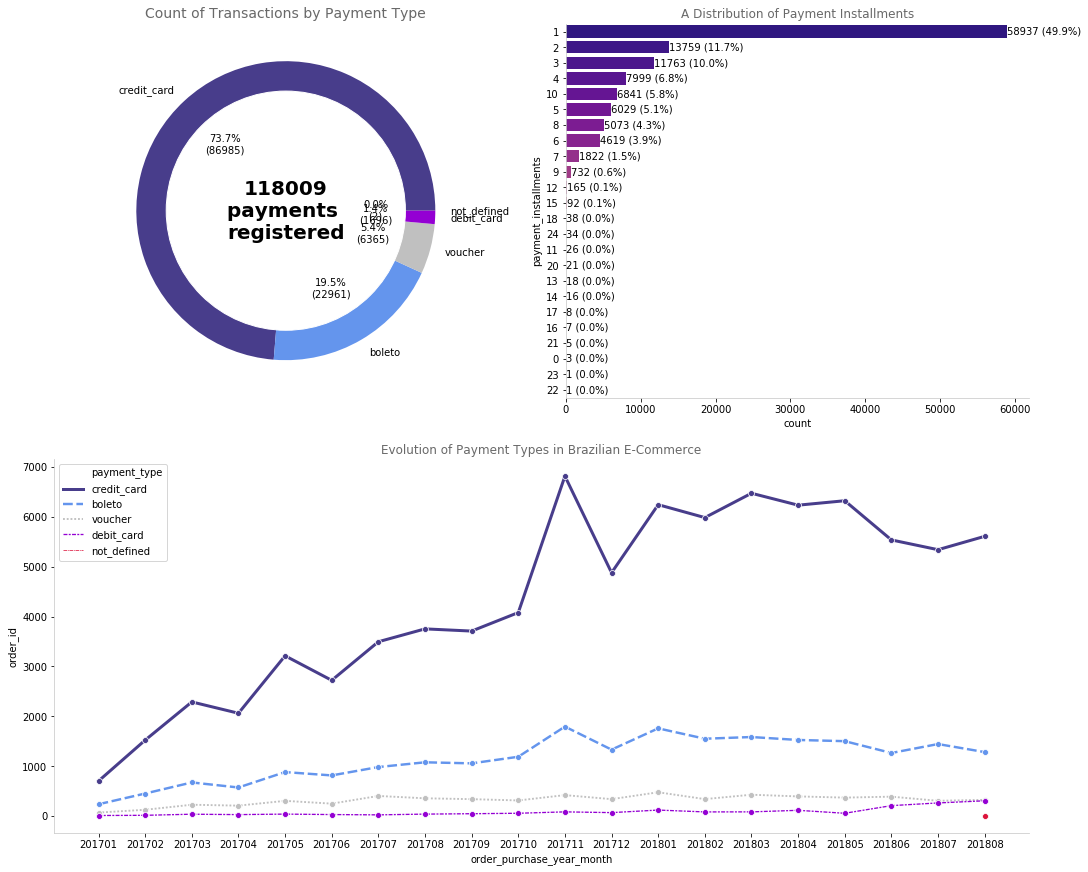

In [113]:
# Grouping data
df_orders_pay = df_orders_filt.merge(olist_order_payments, how='left', on='order_id')

# Creating figure
fig = plt.figure(constrained_layout=True, figsize=(15, 12))

# Axis definition
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

# Plot 1 - Payment types in a donut chart
colors = ['darkslateblue', 'cornflowerblue', 'silver', 'darkviolet', 'crimson']
label_names = df_orders_pay['payment_type'].value_counts().index
donut_plot(df_orders_pay, col='payment_type', ax=ax1, label_names=label_names, colors=colors,
           title='Count of Transactions by Payment Type', text=f'{len(df_orders_pay)}\npayments \nregistered')

# Plot 2 - Payment installments
single_countplot(df_orders_pay, ax=ax2, y='payment_installments')
ax2.set_title('A Distribution of Payment Installments', color='dimgrey', size=12)

# Plot 3 - Evolution of payment types
payment_evl = df_orders_pay.groupby(by=['order_purchase_year_month', 'payment_type'], as_index=False).count()
payment_evl = payment_evl.loc[:, ['order_purchase_year_month', 'payment_type', 'order_id']]
payment_evl = payment_evl.sort_values(by=['order_purchase_year_month', 'order_id'], ascending=[True, False])
sns.lineplot(x='order_purchase_year_month', y='order_id', data=payment_evl, ax=ax3, hue='payment_type',
             style='payment_type', size='payment_type', palette=colors, marker='o')
format_spines(ax3, right_border=False)
ax3.set_title('Evolution of Payment Types in Brazilian E-Commerce', size=12, color='dimgrey')
plt.show()

In fact, we can see by the line chart that payments made by credit card really took marjority place on brazilian e-commerce. Besides that, since 201803 it's possible to see a little decrease on this type of payment. By the other side, payments made by debit card is showing a growing trend since 201805, wich is a good opportunity for investor to improve services for payments like this.

On the bar chart above, we can see how brazilian customers prefer to pay the orders: mostly of them pay once into 1 installment and it's worth to point out the quantity of payments done by 10 installments.

<a id="3.5"></a>
<font color="dimgrey" size=+2.0><b>3.5 Seller Analysis</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>

Seller from different states

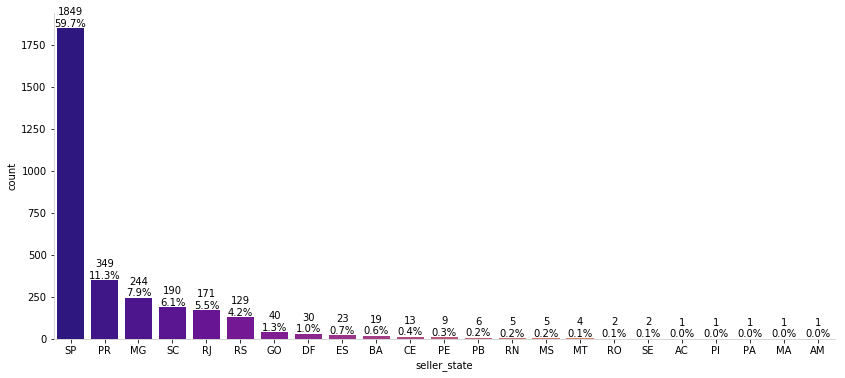

In [114]:
fig, ax = plt.subplots(figsize=(14, 6))
single_countplot(olist_sellers, x='seller_state', ax=ax)
plt.show()

Most of the sellers are from state SP (São Paulo) and most of the orders are coming from this state.

<a id="3.6"></a>
<font color="dimgrey" size=+2.0><b>3.6 Product Analysis</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>

In [115]:
# df_orders.head()
# olist_products = pd.read_csv(raw_path + 'olist_products_dataset.csv')
product_category_name_translation = pd.read_csv(raw_path + 'product_category_name_translation.csv')

product_category_name_translation.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [116]:
olist_products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [117]:
df_products = olist_products.merge(product_category_name_translation, how="left", left_on = "product_category_name", right_on = "product_category_name")
df_products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,art
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0,sports_leisure
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0,baby
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0,housewares


Product category distributions

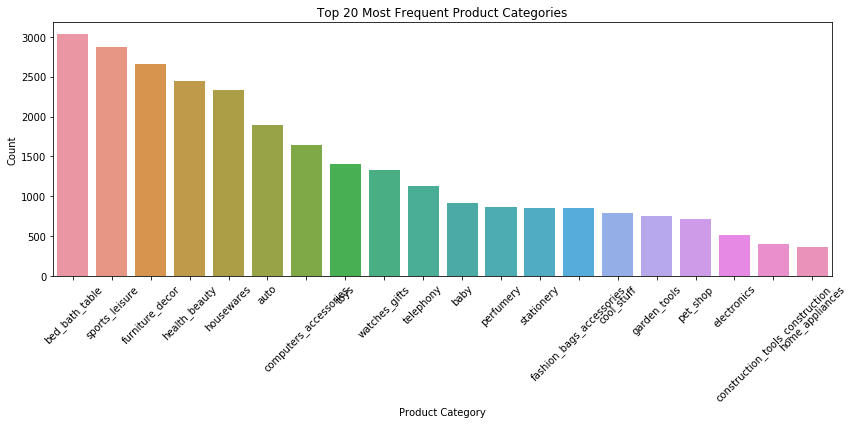

In [118]:
# fig, ax = plt.subplots(figsize=(14, 6))
# single_countplot(df_products, x='product_category_name_english', ax=ax)
# plt.show()

fig, ax = plt.subplots(figsize=(12, 6))

top_10_categories = df_products['product_category_name_english'].value_counts().head(20).index

sns.countplot(x='product_category_name_english', data=df_products, order=top_10_categories, ax=ax)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.title('Top 20 Most Frequent Product Categories')
plt.xlabel('Product Category')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


<a id="3.7"></a>
<font color="dimgrey" size=+2.0><b>3.7 Observation</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>

1. Highest amount of orders went from **delivered** ones. **Only 3%** of all orders came from the other status.
2. Almost **65%** orders are coming from SP, RJ and MG states. This will be helpful, if we can make delivery faster here.

3. E-commerce on Brazil really has a growing trend along the time. We can see some seasonality with peaks at specific months, but in general we can see clear that customers are more prone to buy things online than before.
4. **Monday** are the prefered day for brazilian's customers and they tend to buy more at **afternoons**.

4. _Obs: we have a sharp decrease between August 2018 and September 2018 and maybe the origin of that is related to noise on data. For further comparison between 2017 and 2018, we have considered orders between January and August in both years_
5. We can see a pattern that every month(Jan to Aug) of 2018 number of orders have been **increased significantly** from year 2017. 
6. Data collection is done from Aug 2016, thats is why there is drop in number of orders in this year. But it's clear that there is growth in number of orders from yoy (2017 to 2018)of almost **143%** raise.
7. By the foliumn map, we have already the insight that the **southeast** of Brazil has the **highest number** of orders given through e-commerce. 
8. Highest sales came in month of Nov in year 2017, it is beacuse of **Black friday**.
9. It's very interesting to see how some states have a high total amount sold and a low price per order. If we look at SP (São Paulo) for example, it's possible to see that it is the state with **most valuable state** for e-commerce (5,188,099 sold) but it is also where customers **pay less per order** (110.00 per order).
10. Here we can get insights about the customers states with highest mean freight value. For example, customers in Roraima (RR), Paraíba (PB), Rondônia (RO) and Acre (AC) normaly **pays more than anyone on freights**.
11. Payments made by **credit card really took marjority place** on brazilian e-commerce. Besides that, since 201803 it's possible to see a little decrease on this type of payment. By the other side, payments made by **debit card is showing a growing trend since 201805**, wich is a good opportunity for investor to improve services for payments like this.

12. We can see how brazilian customers prefer to pay the orders: mostly of them pay once into **1 installment (50%)** and it's worth to point out the quantity of payments done by **10 installments**.
14. **Most of the sellers (60%)** are from state SP (São Paulo) and **most of the orders (42%)** are coming from this state only. If we can make proper delivery system inside this state, it will retain many customers (which is not the case, almost 97% customers are one time buyers-  churn analysis done ahead)

<a id="4"></a>
<font color="darkslateblue" size=+2.5><b>4. Predictive Modelling for Delivery time</b></font>

**Predictive Modelling**: Suppose we're interested in predicting the delivery time of a product. How would you create a predictive model for this? What features would you use? Describe your process from data cleaning and preprocessing to model selection and evaluation.

First we have filter out features that will affect delivery time.

<a id="4.1"></a>
<font color="dimgrey" size=+2.0><b>4.1 Understanding and Preparing Data</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>

In [119]:
datasets = [olist_customer, olist_geolocation, olist_orders, olist_order_items, olist_order_payments,
            olist_order_reviews, olist_products, olist_sellers]
for i, dataset in enumerate(datasets):
    print("Columns: ", dataset.columns)

Columns:  Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')
Columns:  Index(['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng',
       'geolocation_city', 'geolocation_state'],
      dtype='object')
Columns:  Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')
Columns:  Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')
Columns:  Index(['order_id', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value'],
      dtype='object')
Columns:  Index(['review_id', 'order_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_t

In [120]:
# df_products = olist_products.merge(product_category_name_translation, how="left", left_on = "product_category_name", right_on = "product_category_name")
x = df_orders_items.merge(olist_sellers, how="left", on = "seller_id")
# print(df_orders_items.shape, x.shape)
# x.head()
y = x.merge(df_products, how="left", on = "product_id")
y.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,id,sigla,nome,nome_regiao,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,seller_zip_code_prefix,seller_city,seller_state,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017,10,Oct,201710,20171002,2,0,Mon,10,Morning,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,35,SP,São Paulo,Sudeste,3149.0,-23.583885,-46.587473,sao paulo,SP,9350.0,maua,SP,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018,7,Jul,201807,20180724,24,1,Tue,20,Night,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,29,BA,Bahia,Nordeste,47813.0,-12.945892,-45.016313,barreiras,BA,31570.0,belo horizonte,SP,perfumaria,29.0,178.0,1.0,400.0,19.0,13.0,19.0,perfumery
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018,8,Aug,201808,20180808,8,2,Wed,8,Morning,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,52,GO,Goiás,Centro-Oeste,75265.0,-16.752735,-48.522139,vianopolis,GO,14840.0,guariba,SP,automotivo,46.0,232.0,1.0,420.0,24.0,19.0,21.0,auto
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017,11,Nov,201711,20171118,18,5,Sat,19,Night,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,24,RN,Rio Grande do Norte,Nordeste,59296.0,-5.778488,-35.281450,sao goncalo do amarante,RN,31842.0,belo horizonte,MG,pet_shop,59.0,468.0,3.0,450.0,30.0,10.0,20.0,pet_shop
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2018,2,Feb,201802,20180213,13,1,Tue,21,Night,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,35,SP,São Paulo,Sudeste,9195.0,-23.760018,-46.524784,santo andre,SP,8752.0,mogi das cruzes,SP,papelaria,38.0,316.0,4.0,250.0,51.0,15.0,15.0,stationery


<a id="4.2"></a>
<font color="dimgrey" size=+2.0><b>4.2 Pre-processing</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>

Exact timestamp wont help much to the predctive model rather than difference bw them.
base ts - **order_purchase_timestamp**

In [121]:
#convert to timestamp
y["order_delivered_customer_date"] = pd.to_datetime(y["order_delivered_customer_date"])
y["shipping_limit_date"] = pd.to_datetime(y["shipping_limit_date"])

#all time diff in hrs
y["order_approved_at_dur"] = (y["order_approved_at"] - y["order_purchase_timestamp"])/ np.timedelta64(1, 'h')
y["order_delivered_carrier_date_dur"] = (y["order_delivered_carrier_date"] - y["order_purchase_timestamp"])/ np.timedelta64(1, 'h')
y["order_delivered_customer_date_dur"] = (y["order_delivered_customer_date"] - y["order_purchase_timestamp"])/ np.timedelta64(1, 'h')
y["order_estimated_delivery_date_dur"] = (y["order_estimated_delivery_date"] - y["order_purchase_timestamp"])/ np.timedelta64(1, 'h')
y["shipping_limit_date_dur"] = (y["shipping_limit_date"] - y["order_purchase_timestamp"])/ np.timedelta64(1, 'h')

z = y.merge(geo_group, how='left', left_on='seller_zip_code_prefix', 
                                        right_on='geolocation_zip_code_prefix',
                                        suffixes = ("_customer", "_seller"))

z.loc[:, "product_size_cm3"] = z['product_length_cm'] * z['product_width_cm'] * z['product_height_cm']
z.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,id,sigla,nome,nome_regiao,geolocation_zip_code_prefix_customer,geolocation_lat_customer,geolocation_lng_customer,geolocation_city_customer,geolocation_state_customer,seller_zip_code_prefix,seller_city,seller_state,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,order_approved_at_dur,order_delivered_carrier_date_dur,order_delivered_customer_date_dur,order_estimated_delivery_date_dur,shipping_limit_date_dur,geolocation_zip_code_prefix_seller,geolocation_lat_seller,geolocation_lng_seller,geolocation_city_seller,geolocation_state_seller,product_size_cm3
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017,10,Oct,201710,20171002,2,0,Mon,10,Morning,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,35,SP,São Paulo,Sudeste,3149.0,-23.583885,-46.587473,sao paulo,SP,9350.0,maua,SP,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,0.178333,56.974167,202.477778,373.057500,96.178333,9350.0,-23.689418,-46.452454,maua,SP,1976.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018,7,Jul,201807,20180724,24,1,Tue,20,Night,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,29,BA,Bahia,Nordeste,47813.0,-12.945892,-45.016313,barreiras,BA,31570.0,belo horizonte,SP,perfumaria,29.0,178.0,1.0,400.0,19.0,13.0,19.0,perfumery,30.713889,41.823056,330.768889,459.306389,126.713889,31570.0,-19.813375,-43.986543,belo horizonte,MG,4693.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018,8,Aug,201808,20180808,8,2,Wed,8,Morning,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,52,GO,Goiás,Centro-Oeste,75265.0,-16.752735,-48.522139,vianopolis,GO,14840.0,guariba,SP,automotivo,46.0,232.0,1.0,420.0,24.0,19.0,21.0,auto,0.276111,5.186389,225.461111,639.353056,120.276111,14840.0,-21.396342,-48.245580,guariba,SP,9576.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017,11,Nov,201711,20171118,18,5,Sat,19,Night,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,24,RN,Rio Grande do Norte,Nordeste,59296.0,-5.778488,-35.281450,sao goncalo do amarante,RN,31842.0,belo horizonte,MG,pet_shop,59.0,468.0,3.0,450.0,30.0,10.0,20.0,pet_shop,0.298056,90.198056,317.010000,628.531667,120.298056,31842.0,-19.919438,-44.022020,belo horizonte,MG,6000.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2018,2,Feb,201802,20180213,13,

In [122]:
data = z[["customer_zip_code_prefix", "geolocation_state_customer", "order_purchase_year", "order_purchase_month",
          "order_purchase_day", "order_purchase_dayofweek", "order_purchase_hour", "order_item_id", "price", "freight_value",
          "geolocation_lat_customer", "geolocation_lng_customer", "product_weight_g", "product_category_name_english",
          "order_approved_at_dur", "order_delivered_carrier_date_dur", "order_delivered_customer_date_dur", "order_estimated_delivery_date_dur",
          "shipping_limit_date_dur", "geolocation_lat_seller", "geolocation_lng_seller", "geolocation_state_seller", "product_size_cm3"
         ]]
print(data.shape)
data.head()

(113425, 23)


,customer_zip_code_prefix,geolocation_state_customer,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_item_id,price,freight_value,geolocation_lat_customer,geolocation_lng_customer,product_weight_g,product_category_name_english,order_approved_at_dur,order_delivered_carrier_date_dur,order_delivered_customer_date_dur,order_estimated_delivery_date_dur,shipping_limit_date_dur,geolocation_lat_seller,geolocation_lng_seller,geolocation_state_seller,product_size_cm3
0,3149,SP,2017,10,2,0,10,1.0,29.99,8.72,-23.583885,-46.587473,500.0,housewares,0.178333,56.974167,202.477778,373.057500,96.178333,-23.689418,-46.452454,SP,1976.0
1,47813,BA,2018,7,24,1,20,1.0,118.70,22.76,-12.945892,-45.016313,400.0,perfumery,30.713889,41.823056,330.768889,459.306389,126.713889,-19.813375,-43.986543,MG,4693.0
2,75265,GO,2018,8,8,2,8,1.0,159.90,19.22,-16.752735,-48.522139,420.0,auto,0.276111,5.186389,225.461111,639.353056,120.276111,-21.396342,-48.245580,SP,9576.0
3,59296,RN,2017,11,18,5,19,1.0,45.00,27.20,-5.778488,-35.281450,450.0,pet_shop,0.298056,90.198056,317.010000,628.531667,120.298056,-19.919438,-44.022020,MG,6000.0
4,9195,SP,2018,2,13,1,21,1.0,19.90,8.72,-23.760018,-46.524784,250.0,stationery,1.030556,22.465278,68.973056,290.689167,143.216111,-23.611175,-46.268467,SP,11475.0


In [123]:
## define a function to get distance from coordinates
from math import radians, sin, cos, asin, sqrt
def haversine_distance(lon1, lat1, lon2, lat2):
    """
    Compute distance between two pairs of (lat, lng)
    dist = acos(sin(lat1)*sin(lat2)+cos(lat1)*cos(lat2)*cos(lon2-lon1))*6371 (6371 is Earth radius in km.)
    """
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    return 2 * 6371 * asin(sqrt(a))

## add distance column to dateset
data['distance'] = data.apply(
    lambda row: haversine_distance(
        row["geolocation_lng_seller"],
        row["geolocation_lat_seller"],
        row["geolocation_lng_customer"],
        row["geolocation_lat_customer"],
    ),
    axis=1,
)
cols = ["customer_zip_code_prefix", "geolocation_lat_customer", "geolocation_lng_customer", "geolocation_lat_seller", "geolocation_lng_seller",
       "order_purchase_day", "order_purchase_hour", "product_category_name_english",
       "geolocation_state_customer", "freight_value", "order_item_id", "order_approved_at_dur", "order_delivered_carrier_date_dur",
        "order_estimated_delivery_date_dur", "shipping_limit_date_dur", "geolocation_state_seller"
       ]
data = data.drop(cols, axis=1)
data.head()

,order_purchase_year,order_purchase_month,order_purchase_dayofweek,price,product_weight_g,order_delivered_customer_date_dur,product_size_cm3,distance
0,2017,10,0,29.99,500.0,202.477778,1976.0,18.079681
1,2018,7,1,118.70,400.0,330.768889,4693.0,771.479181
2,2018,8,2,159.90,420.0,225.461111,9576.0,517.162265
3,2017,11,5,45.00,450.0,317.010000,6000.0,1834.385665
4,2018,2,1,19.90,250.0,68.973056,11475.0,30.905485


Without states for now, will do modelling in second part with these fields

Lets try simple method first, removing all rows which has any row as NaN, it is alright for this case. Have shown down

In [124]:
print(data["distance"].max(), data["distance"].min())
print(data.shape)
filtered_data = data.dropna()
print((data.shape[0] - filtered_data.shape[0])/data.shape[0])
filtered_data.rename(columns={'order_delivered_customer_date_dur':'wait_time'}, inplace=True)
filtered_data.head()

3581.6633048021927 0.0
(113425, 8)
0.033361251928587174


,order_purchase_year,order_purchase_month,order_purchase_dayofweek,price,product_weight_g,wait_time,product_size_cm3,distance
0,2017,10,0,29.99,500.0,202.477778,1976.0,18.079681
1,2018,7,1,118.70,400.0,330.768889,4693.0,771.479181
2,2018,8,2,159.90,420.0,225.461111,9576.0,517.162265
3,2017,11,5,45.00,450.0,317.010000,6000.0,1834.385665
4,2018,2,1,19.90,250.0,68.973056,11475.0,30.905485


Lost data is only 5% out of approx 113k datapoints.

In [125]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

<a id="4.3"></a>
<font color="dimgrey" size=+2.0><b>4.3 Features Correlation</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>

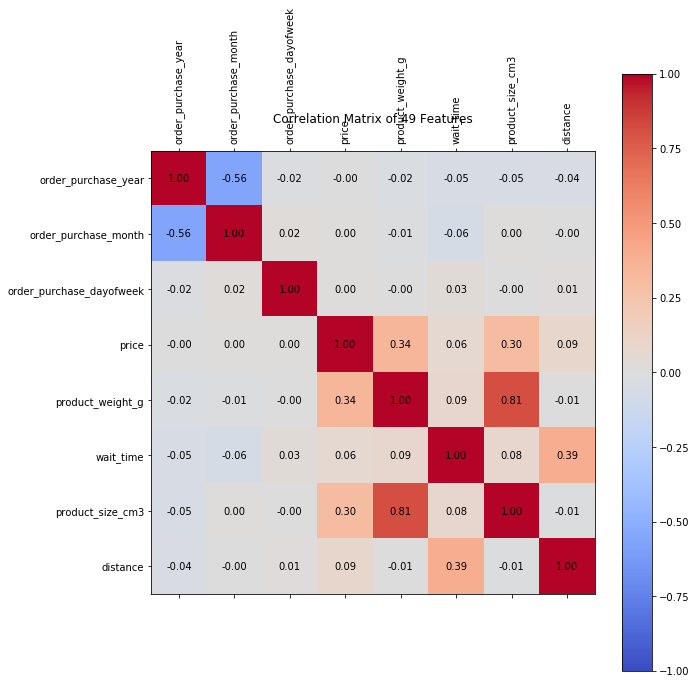

In [126]:
correlations = filtered_data.corr()

fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figure size as needed

cax = ax.matshow(correlations, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)

# Set x-axis and y-axis labels
ax.set_xticks(np.arange(len(correlations.columns)))
ax.set_yticks(np.arange(len(correlations.columns)))
ax.set_xticklabels(correlations.columns, rotation=90)
ax.set_yticklabels(correlations.columns)

# Add a title
ax.set_title('Correlation Matrix of 49 Features')

# Display correlation values on the plot
for i in range(len(correlations.columns)):
    for j in range(len(correlations.columns)):
        text = ax.text(j, i, f'{correlations.iloc[i, j]:.2f}', ha='center', va='center', color='black')

plt.tight_layout()
plt.show()

We can see wait_time is postively correlated with distance, product_size and weight. 

In [127]:
final_df = filtered_data[["price", 'distance', 'product_size_cm3', 'product_weight_g',
                      "wait_time"]]
final_df.head()

,price,distance,product_size_cm3,product_weight_g,wait_time
0,29.99,18.079681,1976.0,500.0,202.477778
1,118.70,771.479181,4693.0,400.0,330.768889
2,159.90,517.162265,9576.0,420.0,225.461111
3,45.00,1834.385665,6000.0,450.0,317.010000
4,19.90,30.905485,11475.0,250.0,68.973056


<a id="4.4"></a>
<font color="dimgrey" size=+2.0><b>4.4 Predictive Modelling</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>

Without any categorical features

# Linear and Random Forrest Regression with Numerical Data

In [128]:
# Pre-processing
scaler = MinMaxScaler()
numerical_features = ["price", "distance", "product_size_cm3", "product_weight_g", "wait_time"]
final_df.loc[:, numerical_features] = scaler.fit_transform(final_df[numerical_features])
final_df.head()

,price,distance,product_size_cm3,product_weight_g,wait_time
0,0.004327,0.005320,0.006107,0.012369,0.037797
1,0.017500,0.227008,0.015285,0.009895,0.063362
2,0.023618,0.152175,0.031779,0.010390,0.042377
3,0.006556,0.539768,0.019700,0.011132,0.060620
4,0.002829,0.009094,0.038194,0.006184,0.011193


In [129]:
# Separate the features and target variable
features = final_df.drop("wait_time", axis=1)
target = final_df["wait_time"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Feature scaling using StandardScaler
scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# Linear Regression model
linear_model = LinearRegression()

# Random Forest Regression model
rf_model = RandomForestRegressor(random_state=42)

# Run for 10 epochs
for epoch in range(10):
    # Fit the models on the scaled training data
    linear_model.fit(X_train, y_train)
    rf_model.fit(X_train, y_train)
    
    # Predict the target variable for the scaled testing data
    linear_predictions = linear_model.predict(X_test)
    rf_predictions = rf_model.predict(X_test)

    # Calculate mean squared error (cost function)
    linear_mse = mean_squared_error(y_test, linear_predictions)
    rf_mse = mean_squared_error(y_test, rf_predictions)

    print("Epoch", epoch + 1)
    print("Linear Regression - MSE:", linear_mse)
    print("Random Forest Regression - MSE:", rf_mse)
    print("=============================")


Epoch 1
Linear Regression - MSE: 0.0015841819844133207
Random Forest Regression - MSE: 0.0015529571004121714
Epoch 2
Linear Regression - MSE: 0.0015841819844133207
Random Forest Regression - MSE: 0.0015529571004121714
Epoch 3
Linear Regression - MSE: 0.0015841819844133207
Random Forest Regression - MSE: 0.0015529571004121714
Epoch 4
Linear Regression - MSE: 0.0015841819844133207
Random Forest Regression - MSE: 0.0015529571004121714
Epoch 5
Linear Regression - MSE: 0.0015841819844133207
Random Forest Regression - MSE: 0.0015529571004121714
Epoch 6
Linear Regression - MSE: 0.0015841819844133207
Random Forest Regression - MSE: 0.0015529571004121714
Epoch 7
Linear Regression - MSE: 0.0015841819844133207
Random Forest Regression - MSE: 0.0015529571004121714
Epoch 8
Linear Regression - MSE: 0.0015841819844133207
Random Forest Regression - MSE: 0.0015529571004121714
Epoch 9
Linear Regression - MSE: 0.0015841819844133207
Random Forest Regression - MSE: 0.0015529571004121714
Epoch 10
Linear Reg

# Neural Networks with Numerical Data 

In [130]:
# Separate the features and target variable
features = final_df.drop("wait_time", axis=1)
target = final_df["wait_time"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Feature scaling using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the neural network model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(4,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

# Train the model
history = model.fit(X_train_scaled, y_train, batch_size=32, epochs=10, verbose=1, validation_data=(X_test_scaled, y_test))

# Evaluate the model
predictions = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("MSE:", mse)
print("R-squared:", r2)

Train on 87712 samples, validate on 21929 samples
Epoch 1/10
87712/87712 [==============================] - 6s 66us/sample - loss: 0.0024 - val_loss: 0.0016
Epoch 2/10
87712/87712 [==============================] - 6s 63us/sample - loss: 0.0018 - val_loss: 0.0015
Epoch 3/10
87712/87712 [==============================] - 5s 61us/sample - loss: 0.0018 - val_loss: 0.0016
Epoch 4/10
87712/87712 [==============================] - 5s 62us/sample - loss: 0.0018 - val_loss: 0.0016
Epoch 5/10
87712/87712 [==============================] - 6s 64us/sample - loss: 0.0017 - val_loss: 0.0016
Epoch 6/10
87712/87712 [==============================] - 6s 73us/sample - loss: 0.0017 - val_loss: 0.0016
Epoch 7/10
87712/87712 [==============================] - 6s 71us/sample - loss: 0.0018 - val_loss: 0.0016
Epoch 8/10
87712/87712 [==============================] - 6s 66us/sample - loss: 0.0018 - val_loss: 0.0016
Epoch 9/10
87712/87712 [==============================] - 6s 69us/sample - loss: 0.0017 - val_

In [131]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                320       
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 2,433
Trainable params: 2,433
Non-trainable params: 0
_________________________________________________________________


Cost function Graph

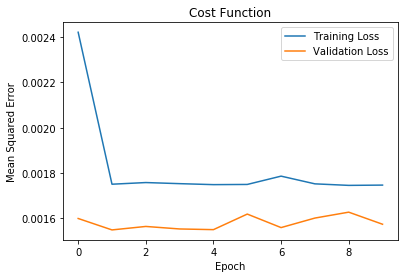

In [132]:
# Extract the cost function values from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the cost function graph
plt.plot(range(len(train_loss)), train_loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Cost Function')
plt.legend()
plt.show()

# Neural Networks

With classification features as well:

In [134]:
data_all = z[["customer_zip_code_prefix", "geolocation_state_customer", "order_purchase_year", "order_purchase_month",
          "order_purchase_day", "order_purchase_dayofweek", "order_purchase_hour", "order_item_id", "price", "freight_value",
          "geolocation_lat_customer", "geolocation_lng_customer", "product_weight_g", "product_category_name_english",
          "order_approved_at_dur", "order_delivered_carrier_date_dur", "order_delivered_customer_date_dur", "order_estimated_delivery_date_dur",
          "shipping_limit_date_dur", "geolocation_lat_seller", "geolocation_lng_seller", "geolocation_state_seller", "product_size_cm3"
         ]]

data_all['distance'] = data_all.apply(
    lambda row: haversine_distance(
        row["geolocation_lng_seller"],
        row["geolocation_lat_seller"],
        row["geolocation_lng_customer"],
        row["geolocation_lat_customer"],
    ),
    axis=1,
)
# data.head()
cols = ["geolocation_lat_customer", "geolocation_lng_customer", "geolocation_lat_seller", "geolocation_lng_seller"]
data_all = data_all.drop(cols, axis=1)
data_all.head()

,customer_zip_code_prefix,geolocation_state_customer,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_item_id,price,freight_value,product_weight_g,product_category_name_english,order_approved_at_dur,order_delivered_carrier_date_dur,order_delivered_customer_date_dur,order_estimated_delivery_date_dur,shipping_limit_date_dur,geolocation_state_seller,product_size_cm3,distance
0,3149,SP,2017,10,2,0,10,1.0,29.99,8.72,500.0,housewares,0.178333,56.974167,202.477778,373.057500,96.178333,SP,1976.0,18.079681
1,47813,BA,2018,7,24,1,20,1.0,118.70,22.76,400.0,perfumery,30.713889,41.823056,330.768889,459.306389,126.713889,MG,4693.0,771.479181
2,75265,GO,2018,8,8,2,8,1.0,159.90,19.22,420.0,auto,0.276111,5.186389,225.461111,639.353056,120.276111,SP,9576.0,517.162265
3,59296,RN,2017,11,18,5,19,1.0,45.00,27.20,450.0,pet_shop,0.298056,90.198056,317.010000,628.531667,120.298056,MG,6000.0,1834.385665
4,9195,SP,2018,2,13,1,21,1.0,19.90,8.72,250.0,stationery,1.030556,22.465278,68.973056,290.689167,143.216111,SP,11475.0,30.905485


In [135]:
filtered_data_all = data_all.dropna()
filtered_data_all.rename(columns={'order_delivered_customer_date_dur':'wait_time'}, inplace=True)
filtered_data_all.shape

(108090, 20)

In [136]:
# OneHot encoding
encode_features = ["order_purchase_year",
                   "order_purchase_month",
                   "order_purchase_dayofweek",
                    "order_purchase_day",
                   "order_purchase_hour",
                   "product_category_name_english",
                    "geolocation_state_seller",
                    'geolocation_state_customer'
                   ]


final_df_all = pd.get_dummies(filtered_data_all, columns = encode_features)

# scale numerical features

numerical_features = ["price", 'distance', 'product_size_cm3', 'product_weight_g',
                      "order_approved_at_dur", "order_delivered_carrier_date_dur", "order_estimated_delivery_date_dur", "shipping_limit_date_dur", 
                        "order_item_id", "freight_value", "wait_time"]
scaler = MinMaxScaler()
# final_df_all.loc[:, numerical_features] = final_df_all[numerical_features]
final_df_all.loc[:, numerical_features] = scaler.fit_transform(final_df_all[numerical_features])
final_df_all.tail()

,customer_zip_code_prefix,order_item_id,price,freight_value,product_weight_g,order_approved_at_dur,order_delivered_carrier_date_dur,wait_time,order_estimated_delivery_date_dur,shipping_limit_date_dur,product_size_cm3,distance,order_purchase_year_2016,order_purchase_year_2017,order_purchase_year_2018,order_purchase_month_1,order_purchase_month_2,order_purchase_month_3,order_purchase_month_4,order_purchase_month_5,order_purchase_month_6,order_purchase_month_7,order_purchase_month_8,order_purchase_month_9,order_purchase_month_10,order_purchase_month_11,order_purchase_month_12,order_purchase_dayofweek_0,order_purchase_dayofweek_1,order_purchase_dayofweek_2,order_purchase_dayofweek_3,order_purchase_dayofweek_4,order_purchase_dayofweek_5,order_purchase_dayofweek_6,order_purchase_day_1,order_purchase_day_2,order_purchase_day_3,order_purchase_day_4,order_purchase_day_5,order_purchase_day_6,order_purchase_day_7,order_purchase_day_8,order_purchase_day_9,order_purchase_day_10,order_purchase_day_11,order_purchase_day_12,order_purchase_day_13,order_purchase_day_14,order_purchase_day_15,order_purchase_day_16,...,product_category_name_english_toys,product_category_name_english_watches_gifts,geolocation_state_seller_AM,geolocation_state_seller_BA,geolocation_state_seller_CE,geolocation_state_seller_DF,geolocation_state_seller_ES,geolocation_state_seller_GO,geolocation_state_seller_MA,geolocation_state_seller_MG,geolocation_state_seller_MS,geolocation_state_seller_MT,geolocation_state_seller_PB,geolocation_state_seller_PE,geolocation_state_seller_PI,geolocation_state_seller_PR,geolocation_state_seller_RJ,geolocation_state_seller_RN,geolocation_state_seller_RO,geolocation_state_seller_RS,geolocation_state_seller_SC,geolocation_state_seller_SE,geolocation_state_seller_SP,geolocation_state_customer_AC,geolocation_state_customer_AL,geolocation_state_customer_AM,geolocation_state_customer_AP,geolocation_state_customer_BA,geolocation_state_customer_CE,geolocation_state_customer_DF,geolocation_state_customer_ES,geolocation_state_customer_GO,geolocation_state_customer_MA,geolocation_state_customer_MG,geolocation_state_customer_MS,geolocation_state_customer_MT,geolocation_state_customer_PA,geolocation_state_customer_PB,geolocation_state_customer_PE,geolocation_state_customer_PI,geolocation_state_customer_PR,geolocation_state_customer_RJ,geolocation_state_customer_RN,geolocation_state_customer_RO,geolocation_state_customer_RR,geolocation_state_customer_RS,geolocation_state_customer_SC,geolocation_state_customer_SE,geolocation_state_customer_SP,geolocation_state_customer_TO
113420,11722,0.00,0.025846,0.049063,0.122449,0.000262,0.620409,0.103591,0.140086,0.003813,0.053479,0.139769,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
113421,45920,0.00,0.030463,0.158709,0.329004,0.000395,0.619765,0.116339,0.185311,0.006674,0.213458,0.290980,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
113422,28685,0.00,0.026602,0.099077,0.162028,0.000178,0.628751,0.079165,0.229203,0.001906,0.026456,0.108305,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
113423,28685,0.05,0.026602,0.099077,0.162028,0.000178,0.628751,0.079165,0.229203,0.001906,0.026456,0.108305,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
113424,83750,0.00,0.010046,0.044815,0.003711,0.019398,0.619038,0.034151,0.150977,0.004360,0.005107,0.187191,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0

In [138]:
# Separate the features and target variable
features = final_df_all.drop("wait_time", axis=1)
target = final_df_all["wait_time"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Feature scaling using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the neural network model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(207,)))
# model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# model is getting overfit by adding one more dense layer

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

# Train the model
history = model.fit(X_train_scaled, y_train, batch_size=32, epochs=10, verbose=1, validation_data=(X_test_scaled, y_test))

# Evaluate the model
predictions = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("MSE:", mse)
print("R-squared:", r2)

Train on 86472 samples, validate on 21618 samples
Epoch 1/10
86472/86472 [==============================] - 9s 99us/sample - loss: 0.0075 - val_loss: 0.0015
Epoch 2/10
86472/86472 [==============================] - 8s 95us/sample - loss: 0.0014 - val_loss: 0.0017
Epoch 3/10
86472/86472 [==============================] - 8s 94us/sample - loss: 0.0016 - val_loss: 0.0020
Epoch 4/10
86472/86472 [==============================] - 8s 94us/sample - loss: 0.0021 - val_loss: 0.0021
Epoch 5/10
86472/86472 [==============================] - 8s 96us/sample - loss: 0.0021 - val_loss: 0.0020
Epoch 6/10
86472/86472 [==============================] - 8s 93us/sample - loss: 0.0021 - val_loss: 0.0020
Epoch 7/10
86472/86472 [==============================] - 8s 95us/sample - loss: 0.0021 - val_loss: 0.0020
Epoch 8/10
86472/86472 [==============================] - 9s 99us/sample - loss: 0.0021 - val_loss: 0.0021
Epoch 9/10
86472/86472 [==============================] - 8s 95us/sample - loss: 0.0021 - val_

In [139]:
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions.flatten()})
print(comparison_df.head(1))

         Actual  Predicted
45172  0.069302   0.053929


In [140]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                13312     
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 15,425
Trainable params: 15,425
Non-trainable params: 0
_________________________________________________________________


Cost function Graph

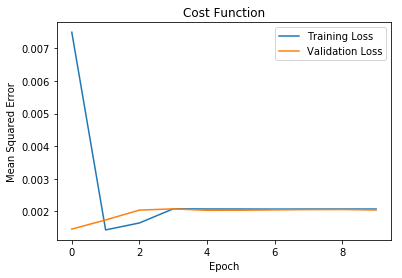

In [141]:
# Extract the cost function values from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the cost function graph
plt.plot(range(len(train_loss)), train_loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Cost Function')
plt.legend()
plt.show()

After 2 epochs training loss and validation loss is almost not changing, we can assume our model learnt successfully after this.

# XG Boost

In [142]:
final_df_all.head()

,customer_zip_code_prefix,order_item_id,price,freight_value,product_weight_g,order_approved_at_dur,order_delivered_carrier_date_dur,wait_time,order_estimated_delivery_date_dur,shipping_limit_date_dur,product_size_cm3,distance,order_purchase_year_2016,order_purchase_year_2017,order_purchase_year_2018,order_purchase_month_1,order_purchase_month_2,order_purchase_month_3,order_purchase_month_4,order_purchase_month_5,order_purchase_month_6,order_purchase_month_7,order_purchase_month_8,order_purchase_month_9,order_purchase_month_10,order_purchase_month_11,order_purchase_month_12,order_purchase_dayofweek_0,order_purchase_dayofweek_1,order_purchase_dayofweek_2,order_purchase_dayofweek_3,order_purchase_dayofweek_4,order_purchase_dayofweek_5,order_purchase_dayofweek_6,order_purchase_day_1,order_purchase_day_2,order_purchase_day_3,order_purchase_day_4,order_purchase_day_5,order_purchase_day_6,order_purchase_day_7,order_purchase_day_8,order_purchase_day_9,order_purchase_day_10,order_purchase_day_11,order_purchase_day_12,order_purchase_day_13,order_purchase_day_14,order_purchase_day_15,order_purchase_day_16,...,product_category_name_english_toys,product_category_name_english_watches_gifts,geolocation_state_seller_AM,geolocation_state_seller_BA,geolocation_state_seller_CE,geolocation_state_seller_DF,geolocation_state_seller_ES,geolocation_state_seller_GO,geolocation_state_seller_MA,geolocation_state_seller_MG,geolocation_state_seller_MS,geolocation_state_seller_MT,geolocation_state_seller_PB,geolocation_state_seller_PE,geolocation_state_seller_PI,geolocation_state_seller_PR,geolocation_state_seller_RJ,geolocation_state_seller_RN,geolocation_state_seller_RO,geolocation_state_seller_RS,geolocation_state_seller_SC,geolocation_state_seller_SE,geolocation_state_seller_SP,geolocation_state_customer_AC,geolocation_state_customer_AL,geolocation_state_customer_AM,geolocation_state_customer_AP,geolocation_state_customer_BA,geolocation_state_customer_CE,geolocation_state_customer_DF,geolocation_state_customer_ES,geolocation_state_customer_GO,geolocation_state_customer_MA,geolocation_state_customer_MG,geolocation_state_customer_MS,geolocation_state_customer_MT,geolocation_state_customer_PA,geolocation_state_customer_PB,geolocation_state_customer_PE,geolocation_state_customer_PI,geolocation_state_customer_PR,geolocation_state_customer_RJ,geolocation_state_customer_RN,geolocation_state_customer_RO,geolocation_state_customer_RR,geolocation_state_customer_RS,geolocation_state_customer_SC,geolocation_state_customer_SE,geolocation_state_customer_SP,geolocation_state_customer_TO
0,3149,0.0,0.004327,0.021285,0.012369,0.000241,0.623790,0.037797,0.088397,0.001908,0.006107,0.005320,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,47813,0.0,0.017500,0.055556,0.009895,0.041424,0.621521,0.063362,0.111866,0.003120,0.015285,0.227008,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,75265,0.0,0.023618,0.046915,0.010390,0.000372,0.616035,0.042377,0.160858,0.002864,0.031779,0.152175,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,59296,0.0,0.006556,0.066393,0.011132,0.000402,0.628764,0.060620,0.157913,0.002865,0.019700,0.539768,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,9195,0.0,0.002829,0.021285,0.006184,0.001390,0.618623,0.011193,0.065985,0.003774,0.038194,0.009094,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0

In [143]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Assuming you have your dataset with features (X) and target variable (y)
xg_features = final_df_all.drop("wait_time", axis=1)
xg_target = final_df_all["wait_time"]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(xg_features, xg_target, test_size=0.2, random_state=42)

# Create an instance of the XGBoost regressor
xgboost_model = xgb.XGBRegressor()

# Track the cost function (mean squared error) across epochs
# train_errors = []
# test_errors = []

# # Train the model for multiple epochs
# num_epochs = 1
# for epoch in range(num_epochs):
    # Fit the model to the training data
xgboost_model.fit(X_train, y_train)

# Make predictions on the training and test sets
y_train_pred = xgboost_model.predict(X_train)
y_test_pred = xgboost_model.predict(X_test)

# Calculate the mean squared errors
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

# Append the errors to the lists
# train_errors.append(train_mse)
# test_errors.append(test_mse)

print(f"Epoch {epoch+1}: Train MSE = {train_mse:.10f}, Test MSE = {test_mse:.4f}")
mse = mean_squared_error(y_test, y_test_pred)
print("Mean Squared Error:", mse)

[10:32:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Epoch 10: Train MSE = 0.0011327570, Test MSE = 0.0012
Mean Squared Error: 0.001153563643333681


In [144]:
print(list(y_test)[0], y_test_pred[0])
print(list(y_test)[199], y_test_pred[199])

0.06930228760657207 0.07002923
0.04209129668863725 0.04340121


<a id="4.5"></a>
<font color="dimgrey" size=+2.0><b>4.5 Conclusion and Future works</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>


Regression models summary shown in following table:


| Regression Model                             | MSE    |
|----------------------------------------------|--------|
| Linear Regression                            | 0.7765 |
| Random Forest Regression                     | 0.7602 |
| Neural Networks                              | 0.7544 |
| Neural Networks (Categorical cols included)  | 0.0020 |
| XGBoost (Categorical cols included)          | 0.0011 |


First three models have very high mse beacuse we haven't considered categorical features, and clearly it got improved drastically after adding it.

Future works involves:
1. Cleaning the data more carefullly.
2. Fine tuning our model hyperparameters.
3. Implementing more regression models for better predictions
4. Different error matrix can be used
<!-- 4. Future works involve tuning hyper parameters eg. nn depth, batch size and learning rate. -->

<a id="5"></a>
<font color="dimgrey" size=+2.0><b>5. Time Series Analysis</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>

Extending analysis from total orders from **Section 3.1**

Time Series Analysis: The dataset contains information about orders from 2016 to 2018. Can you analyze the time series data to find any seasonality or trends in the orders? How would you forecast the number of orders for the next quarter?

In [145]:
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017,10,Oct,201710,20171002,2,0,Mon,10,Morning
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018,7,Jul,201807,20180724,24,1,Tue,20,Night
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018,8,Aug,201808,20180808,8,2,Wed,8,Morning
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017,11,Nov,201711,20171118,18,5,Sat,19,Night
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2018,2,Feb,201802,20180213,13,1,Tue,21,Night


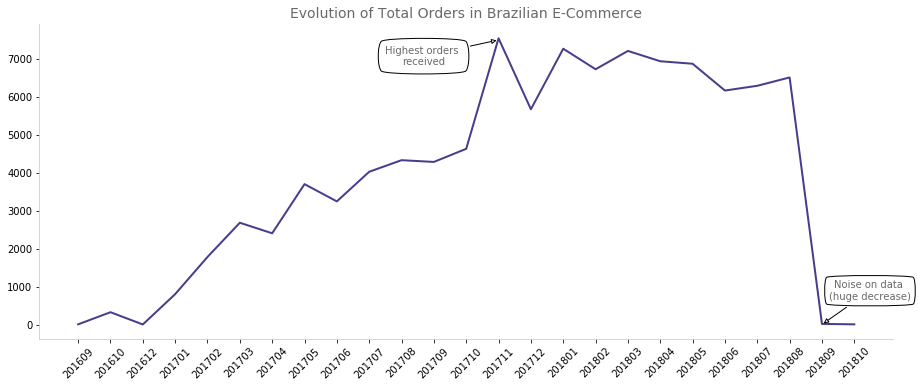

In [146]:
fig = plt.figure(constrained_layout=True, figsize=(13, 10))

# Axis definition
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
# ax2 = fig.add_subplot(gs[1, 0])
# ax3 = fig.add_subplot(gs[1, 1])

# Lineplot - Evolution of e-commerce orders along time 
sns.lineplot(data=df_orders['order_purchase_year_month'].value_counts().sort_index(), ax=ax1, 
             color='darkslateblue', linewidth=2)
ax1.annotate(f'Highest orders \nreceived', (13, 7500), xytext=(-75, -25), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.8),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')
ax1.annotate(f'Noise on data \n(huge decrease)', (23, 0), xytext=(48, 25), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.5),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')
format_spines(ax1, right_border=False)  
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
ax1.set_title('Evolution of Total Orders in Brazilian E-Commerce', size=14, color='dimgrey')


plt.tight_layout()
plt.show()

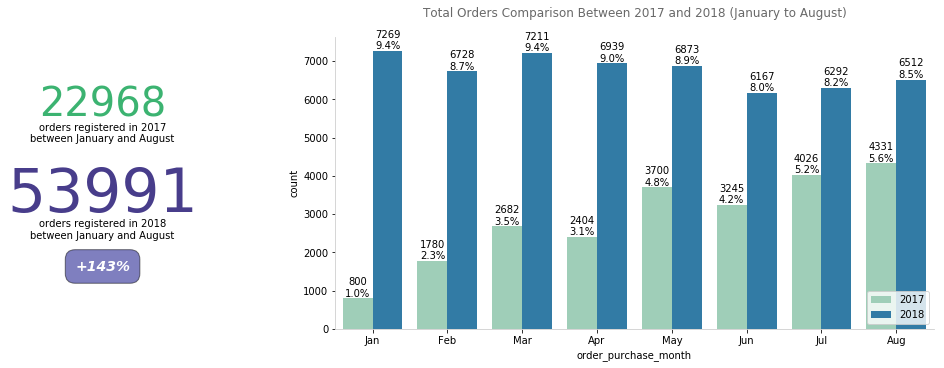

In [147]:
# Creating figure
fig = plt.figure(constrained_layout=True, figsize=(13, 5))

# Axis definition
gs = GridSpec(1, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1:])

# Annotation - Grown on e-commerce orders between 2017 and 2018
df_orders_compare = df_orders.query('order_purchase_year in (2017, 2018) & order_purchase_month <= 8')
year_orders = df_orders_compare['order_purchase_year'].value_counts()
growth = int(round(100 * (1 + year_orders[2017] / year_orders[2018]), 0))
ax1.text(0.00, 0.73, f'{year_orders[2017]}', fontsize=40, color='mediumseagreen', ha='center')
ax1.text(0.00, 0.64, 'orders registered in 2017\nbetween January and August', fontsize=10, ha='center')
ax1.text(0.00, 0.40, f'{year_orders[2018]}', fontsize=60, color='darkslateblue', ha='center')
ax1.text(0.00, 0.31, 'orders registered in 2018\nbetween January and August', fontsize=10, ha='center')
signal = '+' if growth > 0 else '-'
ax1.text(0.00, 0.20, f'{signal}{growth}%', fontsize=14, ha='center', color='white', style='italic', weight='bold',
         bbox=dict(facecolor='navy', alpha=0.5, pad=10, boxstyle='round, pad=.7'))
ax1.axis('off')

# Bar chart - Comparison between monthly sales between 2017 and 2018
single_countplot(df_orders_compare, x='order_purchase_month', hue='order_purchase_year', ax=ax2, order=False,
                 palette='YlGnBu')
month_label = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']
ax2.set_xticklabels(month_label)
ax2.set_title('Total Orders Comparison Between 2017 and 2018 (January to August)', size=12, color='dimgrey', pad=20)
plt.legend(loc='lower right')
plt.show()

In [148]:
#Filtered orders 2017-18 between Jan to Aug
# df_orders_compare.head()
print(df_orders_compare.shape, df_orders_compare["order_id"].nunique(), sorted(df_orders_compare["order_purchase_month"].unique()))

(76959, 22) 76959 [1, 2, 3, 4, 5, 6, 7, 8]


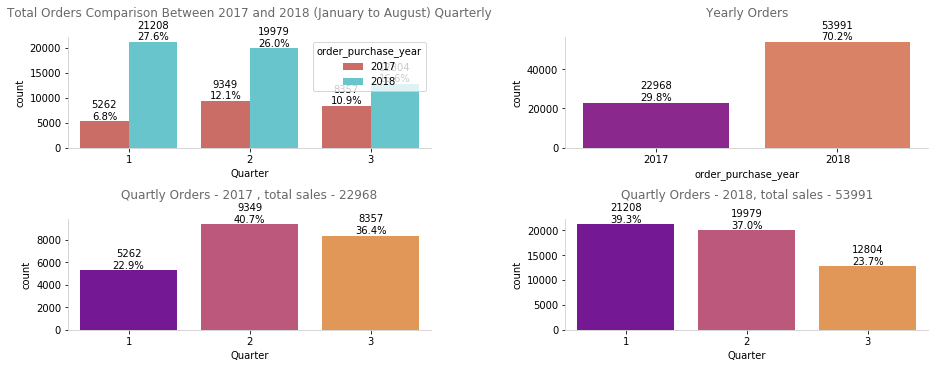

In [149]:
# tmp = pd.DataFrame()
tmp = df_orders_compare.copy()
tmp["Quarter"] = pd.to_datetime(df_orders_compare['order_purchase_timestamp'], format='%m').dt.quarter
# tmp["month"] = df_orders_compare['order_purchase_month']

# grouped_data = df_orders_compare.groupby(df_orders_compare['order_purchase_month'].map(lambda x: 'Q 1' if x in [1, 2, 3, 4] else 'Q 2'), df_orders_compare["order_purchase_year"])['order_id'].count()
# grouped_data.head()
# tmp.head()

# Creating figure
fig = plt.figure(constrained_layout=True, figsize=(13, 5))

# Axis definition
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

# Bar chart - Comparison between quarterly sales between 2017 and 2018
single_countplot(tmp, x='Quarter', hue='order_purchase_year', ax=ax1, order=False,
                 palette='hls')
quarter = ['1', '2', '3']
ax1.set_xticklabels(quarter)
ax1.set_title('Total Orders Comparison Between 2017 and 2018 (January to August) Quarterly', size=12, color='dimgrey', pad=20)

# Yearly orders
ax2.set_title('Yearly Orders', size=12, color='dimgrey', pad=20)
single_countplot(tmp, x='order_purchase_year', ax=ax2, order=False)

# Sale 2017
tmp_2017 = tmp.query('order_purchase_year == 2017 & order_purchase_month <= 8')
single_countplot(tmp_2017, x='Quarter', ax=ax3, order=False)
ax3.set_title(f'Quartly Orders - 2017 , total sales - {tmp_2017.shape[0]}', size=12, color='dimgrey', pad=20)

# Sale 2018
tmp_2018 = tmp.query('order_purchase_year == 2018 & order_purchase_month <= 8')
single_countplot(tmp_2018, x='Quarter', ax=ax4, order=False)
ax4.set_title(f'Quartly Orders - 2018, total sales - {tmp_2018.shape[0]}', size=12, color='dimgrey', pad=20)

plt.show()

In [150]:
# Q1
# print("Q1 :", tmp_2017["Quarter"].value_counts()[1])
# tmp_2017.info()
l=[]
for i in range(1, 4):
    Q17 = tmp_2017["Quarter"].value_counts()[i]
    Q18 = tmp_2018["Quarter"].value_counts()[i]
    d = { f"Q{i}" : { "2017 Orders": Q17, "2018 Orders": Q18 , "% increase": int(round(100*(1 + Q17/Q18 ), 0)) } }
    l.append(d)
print(l)

[{'Q1': {'2017 Orders': 5262, '2018 Orders': 21208, '% increase': 125}}, {'Q2': {'2017 Orders': 9349, '2018 Orders': 19979, '% increase': 147}}, {'Q3': {'2017 Orders': 8357, '2018 Orders': 12804, '% increase': 165}}]


1. Quarter wise orders:
| Quarter | 2017 Orders | 2018 Orders | % increase |
|---------|-------------|-------------|------------|
| Q1      | 5262        | 21208       | 125        |
| Q2      | 9349        | 19979       | 147        |
| Q3      | 8357        | 12804       | 165        |

2. Based on above analysis, we can implement models for prediction of total orders for next year quarters.

<a id="6"></a>
<font color="darkslateblue" size=+2.5><b>6. Churn Prediction</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>

In [151]:
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017,10,Oct,201710,20171002,2,0,Mon,10,Morning
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018,7,Jul,201807,20180724,24,1,Tue,20,Night
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018,8,Aug,201808,20180808,8,2,Wed,8,Morning
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017,11,Nov,201711,20171118,18,5,Sat,19,Night
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2018,2,Feb,201802,20180213,13,1,Tue,21,Night


In [152]:
df_count_cust = df_orders.groupby(['customer_unique_id']).count().reset_index()
df_count_cust["order_count"] = df_count_cust["order_id"]
# df_count_cust = df_count_cust.drop(["order_id", "year_month", "payment_value", "time_to_shop","order_purchase_year"], axis=1)
df_count_cust = df_count_cust.groupby(["order_count"]).count().reset_index().rename(columns={"customer_unique_id": "num_customer"})
df_count_cust["percentage_customer"] = 100.0 * df_count_cust["num_customer"] / df_count_cust["num_customer"].sum()
df_count_cust[["order_count", "num_customer", "percentage_customer"]]

,order_count,num_customer,percentage_customer
0,1,93099,96.881244
1,2,2745,2.856518
2,3,203,0.211247
3,4,30,0.031219
4,5,8,0.008325
5,6,6,0.006244
6,7,3,0.003122
7,9,1,0.001041
8,17,1,0.001041


There is almost 97 percent customers purchaging only one time, it wont be very useful if we use predective models for chrun.

<a id="7"></a>
<font color="darkslateblue" size=+2.5><b>7. Natural Language Processing</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>

In [153]:
reviews = olist_order_reviews.copy()
reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [154]:
p_5s = len(reviews[reviews['review_score'] == 5]) * 100 / len(reviews)
p_1s = len(reviews[reviews['review_score'] == 1]) * 100 / len(reviews)
first_dt = reviews['review_creation_date'].min()
last_dt = reviews['review_creation_date'].max()
avg_s = reviews['review_score'].mean()
print(len(reviews), 'reviews')
print('First:', first_dt)
print('Last:', last_dt)
print(f'5 star: {p_5s:.1f}%')
print(f'1 star: {p_1s:.1f}%')
print(f'Average: {avg_s:.1f} star')

99224 reviews
First: 2016-10-02 00:00:00
Last: 2018-08-31 00:00:00
5 star: 57.8%
1 star: 11.5%
Average: 4.1 star


In [155]:
reviews['review_answer_timestamp'] = pd.to_datetime(reviews.review_answer_timestamp)
reviews['review_creation_date'] = pd.to_datetime(reviews.review_creation_date)
reviews.dropna(inplace = True)
print("Total review comments:", len(reviews))

Total review comments: 9839


In [156]:
p_5s = len(reviews[reviews['review_score'] == 5]) * 100 / len(reviews)
p_1s = len(reviews[reviews['review_score'] == 1]) * 100 / len(reviews)
first_dt = reviews['review_creation_date'].min()
last_dt = reviews['review_creation_date'].max()
avg_s = reviews['review_score'].mean()
print(len(reviews), 'reviews')
print('First:', first_dt)
print('Last:', last_dt)
print(f'5 star: {p_5s:.1f}%')
print(f'1 star: {p_1s:.1f}%')
print(f'Average: {avg_s:.1f} star')

9839 reviews
First: 2017-05-16 00:00:00
Last: 2018-08-31 00:00:00
5 star: 55.1%
1 star: 18.2%
Average: 3.8 star


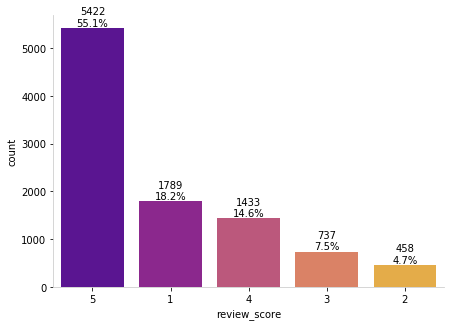

In [157]:
# rating plot
fig, ax = plt.subplots(figsize=(7, 5))
single_countplot(reviews, x='review_score', ax=ax)
plt.show()

Almost **55%** customers are satisfied, and **18%** are upset.

In [158]:
!pip install deep_translator
from deep_translator import GoogleTranslator
top_comments = reviews.review_comment_title.value_counts()[:10]
print('The top 20 comments by the customer are:',top_comments,sep='\n')

The top 20 comments by the customer are:
Recomendo          354
recomendo          270
Bom                228
super recomendo    213
Excelente          203
Ótimo              193
Muito bom          192
Super recomendo    184
Ótimo              149
Otimo              133
Name: review_comment_title, dtype: int64


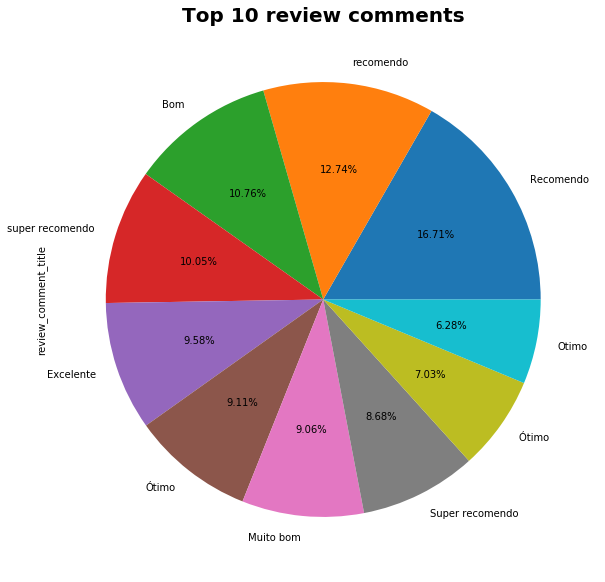

In [159]:
top_comments.plot(kind="pie",autopct="%2.2f%%",figsize=(10, 10))
plt.title('Top 10 review comments',fontweight='bold',fontsize=20)
plt.show()

Recomendo is almost **30%** including both (recomendo and Recomendo), and Super recomendo is **18.73%** (Super recomendo and super recomendo).

In [160]:
# Convert series to df
tc = pd.DataFrame(list(top_comments.items()), columns=['comment', 'vcount'])

top_comments_english = (tc.comment).apply(lambda x: {x: GoogleTranslator(source='pt', target='en').translate(x)})
print('The top 20 comments in English by the customer are:',top_comments_english,sep='\n')

The top 20 comments in English by the customer are:
0               {'Recomendo': 'I recommend'}
1               {'recomendo': 'I recommend'}
2                            {'Bom': 'Good'}
3    {'super recomendo': 'highly recommend'}
4                     {'Excelente': 'Great'}
5                     {'Ótimo': 'Excellent'}
6                 {'Muito bom': 'Very good'}
7    {'Super recomendo': 'highly recommend'}
8                    {'Ótimo ': 'Excellent'}
9                     {'Otimo': 'Excellent'}
Name: comment, dtype: object


In [161]:
reviews_bin = pd.DataFrame(reviews["review_comment_message"], columns=["review_comment_message"])
def partition(x):
    if x < 3:
        return 0
    return 1

reviews_bin["review_score"] = reviews.review_score.map(lambda comment: partition(comment))
reviews_bin.head()

,review_comment_message,review_score
9,aparelho eficiente. no site a marca do aparelh...,1
15,"Vendedor confiável, produto ok e entrega antes...",1
19,Péssimo,0
22,Loja nota 10,1
34,Recebi exatamente o que esperava. As demais en...,1


Total Positive Reviews : 7592 , ( 77.16231324321578 %)
Total Negative Reviews : 2247 , ( 22.837686756784226 %)




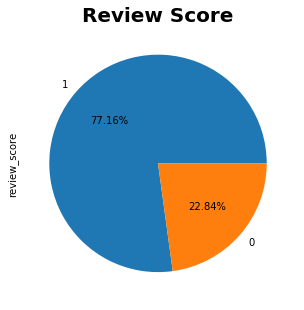

In [162]:
#counting the review score with 1 and 0
y_value_counts = reviews_bin.review_score.value_counts()

#calculating the percentage of each review type
print("Total Positive Reviews :", y_value_counts[1], ", (", (y_value_counts[1]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print("Total Negative Reviews :", y_value_counts[0], ", (", (y_value_counts[0]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print('\n')

#plotting bar-plot and pie chart
y_value_counts.plot(kind="pie",autopct="%2.2f%%",figsize=(5, 5))
plt.title('Review Score',fontweight='bold',fontsize=20)
plt.show()

**77%** are positive reviews, and remaining almost **23%** are negative.

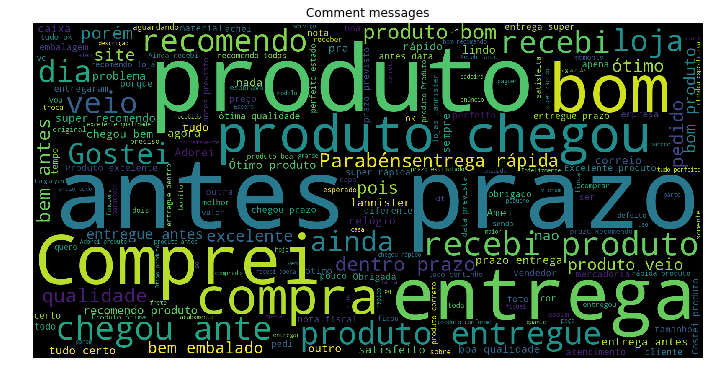

In [163]:
# Word cloud
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

stop_words = stopwords.words('portuguese')
wordcloud = WordCloud(stopwords=stop_words,
                      background_color="black",
                      width=1600, height=800).generate(' '.join(reviews_bin["review_comment_message"]))
fig, ax = plt.subplots(figsize=(12,10))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.title("Comment messages")
plt.imshow(wordcloud)

**antes prazo(before deadline), producto(product) and entrega(delivery)** are most frequent words in review messgages.

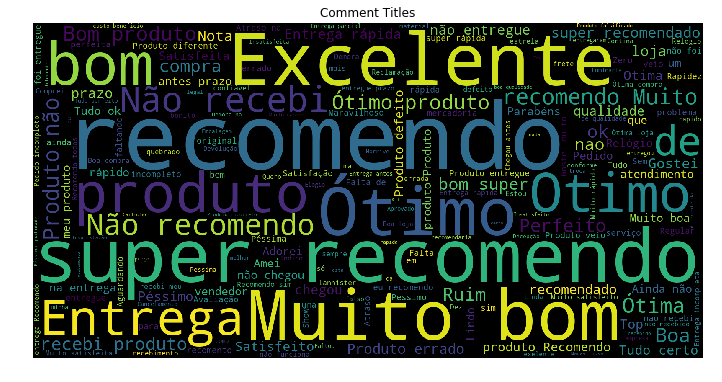

In [164]:
wordcloud = WordCloud(background_color="black",
                      width=1600, height=800).generate(' '.join(reviews.review_comment_title))
fig, ax = plt.subplots(figsize=(12,10))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.title("Comment Titles")
plt.imshow(wordcloud)

super recomendo, bom, recomendo, Excelente and Otimo **(super recommend, good, recommend, Excellent and Great)** are **very frequent** in comment titles.

# Future Works
1. Implementation of **service classification models** for comment messages. Classes could be **Delivery, Packaging, Payment satisfaction, Product** etc.
2. **Sentiment Analysis** for text comment, and classify is **positive or negative**. Appropriate decision could be taken based on that. 

# Thanks!
Ref - https://www.kaggle.com/code/thiagopanini/e-commerce-sentiment-analysis-eda-viz-nlp